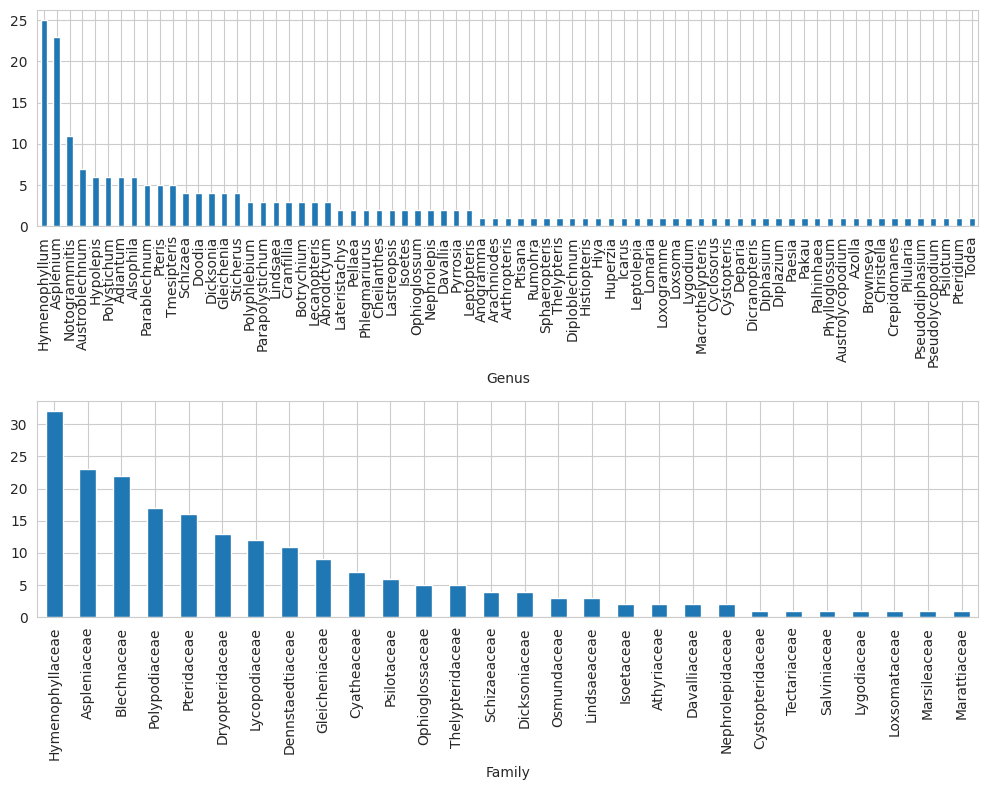

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
data_path = Path('data/Ferns')

def load_raster(f, grid_step=.1):
    raster = xr.open_dataarray(f)
    current_step = (raster.x[1] - raster.x[0]).values # degrees
    downsample = round(grid_step / current_step)
    raster = raster.coarsen(x=downsample, y=downsample, boundary="trim").sum()
    return raster

species_list = pd.read_excel(data_path / 'Species list.xlsx')
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
species_list.Genus.value_counts().plot(kind='bar', ax=ax[0])
species_list.Family.value_counts().plot(kind='bar', ax=ax[1])
plt.tight_layout()
plt.show()

# Data inspection

## Traits

NameError: name 'dataset' is not defined

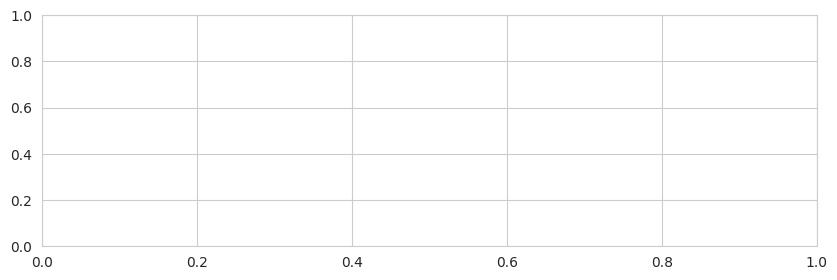

In [2]:
traits = pd.read_excel(data_path / 'Traits.xlsx')
traits_mean = pd.read_excel(data_path / 'Traits.xlsx', sheet_name='Mean').set_index('Species')
traits_var = pd.read_excel(data_path / 'Traits.xlsx', sheet_name='Var').drop(columns=['Family', 'Habitat', 'Hybridisation']).set_index('Species')
traits_std = traits_var.apply(np.sqrt).rename(columns=lambda x: x.replace('Var', 'Std'))

traits_all = traits_mean.join(traits_std)
traits_all = traits_all.drop(index='Hymenophyllum_falklandicum') # missing information
# traits_all.columns = traits_all.columns.map('_'.join)

fig, ax = plt.subplots(figsize=(10, 3))
(dataset.dataset.dataset.dataset.traits_all.isna().sum().sort_values() / len(traits_mean)).plot(kind='bar', ax=ax, title='Missing values')
plt.axhline(y=.6, color='r', linestyle='--', lw=1)
plt.show()

In [3]:
list(zip(sorted(traits_mean.columns[traits_mean.dtypes.eq('float64')&(traits_mean.columns!='Hybridisation')&~traits_mean.columns.str.startswith('Rhizome')]), sorted(traits_var.columns[traits_var.dtypes == 'float64'])))

[('Altmean', 'AltRange'),
 ('Ferstipemean', 'FerstipeVar'),
 ('Fertile frond mean', 'FertfrondVar'),
 ('Fertlaminamean', 'FertlaminaVar'),
 ('Fertlamlengthmean', 'FertlaminalengthVar'),
 ('Fertlamwidthmean', 'FertlaminawidthVar'),
 ('Frondmean', 'FrondVar'),
 ('Laminalengthmean', 'LaminaVar'),
 ('Laminareamean', 'LaminalengthVar'),
 ('Laminawidthmean', 'LaminawidthVar'),
 ('Sporemean', 'SporeVar'),
 ('Stipemean', 'StipeVar')]

In [4]:
for cl_feat in ['Habitat', 'Family']:
    for cl in traits_all[cl_feat].unique():
        if traits_all[cl_feat].eq(cl).sum() < len(traits_all) * 0.05:
            traits_all[cl_feat] = traits_all[cl_feat].replace({cl: 'Other'})
traits_all = pd.get_dummies(traits_all, drop_first=True)

class_idx = {
    'Habitat': [traits_all.columns.get_loc(c) for c in traits_all.columns if c.startswith('Habitat')],
    'Family': [traits_all.columns.get_loc(c) for c in traits_all.columns if c.startswith('Family')],
}
# df = df.drop(columns=[c for c in df.columns if c.startswith('Habitat') or c.startswith('Family')])

## Species Graph

In [233]:
from Bio import Phylo

# Load the tree
tree_file = data_path/"grafted_tree.nwk"
tree = Phylo.read(tree_file, "newick")

# Print a text-based visualization
Phylo.draw_ascii(tree)


                      _________ Anogramma_leptophylla
                     |
                     |   ______ Pteris_epaleata
                _____|  |
               |     |  |      , Pteris_macilenta
               |     |  |    __|
               |     |__|___|  | Pteris_saxatilis
               |        |   |
               |        |   |__ Pteris_tremula
               |        |
               |        |______ Pteris_carsei
            ___|
           |   |              , Cheilanthes_distans
           |   |          ____|
           |   |         |    | Cheilanthes_sieberi
           |   | ________|
           |   ||        |     , Pellaea_calidirupia
           |   ||        |_____|
           |   ||              | Pellaea_rotundifolia
           |   ||
           |   ||             , Adiantum_aethiopicum
           |    |             |
           |    |             | Adiantum_hispidulum
           |    |           __|
           |    |          |  |, Adiantum_cunninghamii
     

In [234]:
# tree to networkx
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for clade in tree.get_nonterminals():  # Internal nodes (non-leaf)
    if clade.name is None:
        clade.name = f"temp_{id(clade)}"
    for child in clade.clades:
        if child.name is None:
            child.name = f"temp_{id(child)}"
        G.add_edge(clade.name, child.name, weight=child.branch_length)

# Visualize graph info
print("Graph nodes:", G.nodes())
print("Graph edges:", G.edges(data=True))

Graph nodes: ['temp_138583587690288', 'temp_138574013438656', 'temp_138574336036544', 'temp_138574013178624', 'Ptisana_salicina', 'temp_138574013183472', 'temp_138574336043744', 'temp_138574013175408', 'temp_138581818241008', 'temp_138574013185584', 'temp_138581818243840', 'temp_138574013619408', 'temp_138581818240624', 'temp_138574013613744', 'temp_138581818231360', 'temp_138574013626560', 'temp_138581818237168', 'temp_138574013624880', 'temp_138574013620944', 'temp_138574013617920', 'temp_138574013624736', 'Anogramma_leptophylla', 'temp_138574013626944', 'Pteris_epaleata', 'temp_138574013616288', 'Pteris_carsei', 'temp_138574013615616', 'Pteris_tremula', 'Pteris_macilenta', 'Pteris_saxatilis', 'temp_138574013614512', 'temp_138574013622720', 'temp_138574013627904', 'temp_138574013620608', 'Cheilanthes_distans', 'Cheilanthes_sieberi', 'Pellaea_calidirupia', 'Pellaea_rotundifolia', 'temp_138574013618064', 'Adiantum_formosum', 'temp_138574013617488', 'temp_138574013623392', 'Adiantum_aet

In [235]:
from node2vec import Node2Vec

# Train Node2Vec model
node2vec = Node2Vec(G, dimensions=16, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Create node embeddings
node_embeddings = {node: model.wv[node] for node in G.nodes()}

Computing transition probabilities: 100%|██████████| 374/374 [00:00<00:00, 47940.76it/s]


Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 45.10it/s]


In [236]:
import itertools

leaf_nodes = [leaf.name for leaf in tree.get_terminals()]

G_species = nx.Graph()


# Compute pairwise phylogenetic distances between all leaves
for species1, species2 in itertools.combinations(leaf_nodes, 2):
    dist = tree.distance(species1, species2)  # Compute phylogenetic distance
    G_species.add_edge(species1, species2, weight=dist)

# Print some info
print("Total nodes (species only):", len(G_species.nodes))
print("Total edges before pruning:", len(G_species.edges))

median = np.median([d["weight"] for u, v, d in G_species.edges(data=True)])
print(f"Median distance: {median}\n")
sym_threshold = median

# Prune the graph by removing edges with weight > sym_threshold
edges_to_remove = [(u, v) for u, v, d in G_species.edges(data=True) if d["weight"] > sym_threshold]
G_species.remove_edges_from(edges_to_remove)
print("Number of connected components:", nx.number_connected_components(G_species))
print("Total edges after pruning:", len(G_species.edges))

Total nodes (species only): 190
Total edges before pruning: 17955
Median distance: 697.767902

Number of connected components: 7
Total edges after pruning: 9057


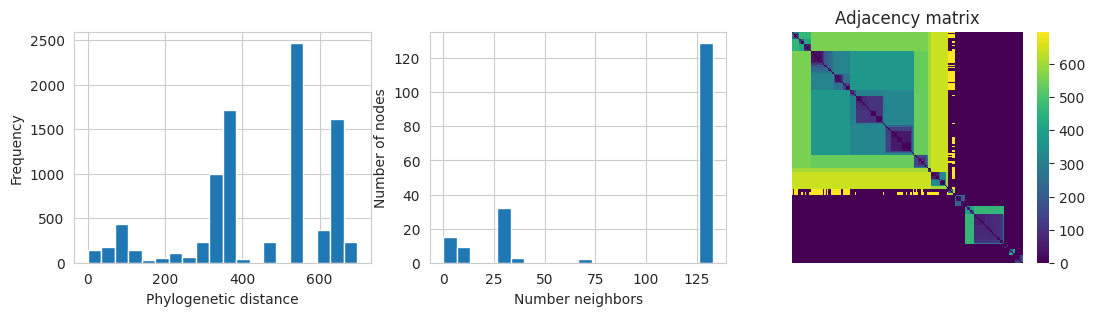

In [237]:
# histogram of the distances
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
ax[0].hist([d['weight'] for _, _, d in G_species.edges(data=True)], bins=20)
ax[0].set_xlabel("Phylogenetic distance")
ax[0].set_ylabel("Frequency")

ax[1].set_xlabel("Number neighbors")
ax[1].set_ylabel("Number of nodes")
ax[1].hist([len(list(G_species.neighbors(n))) for n in G_species.nodes], bins=20)

sns.heatmap(nx.to_numpy_array(G_species), cmap="viridis", xticklabels=False, yticklabels=False, ax=ax[2], square=True)
ax[2].set_title("Adjacency matrix")
plt.show()

In [238]:
import torch
from torch_geometric.utils import from_networkx

# Remove species not present in the traits
G_species.remove_nodes_from(list(set(G_species.nodes).difference(traits_all.index)))

for node in G_species.nodes():
    G_species.nodes[node]["x"] = node_embeddings[node]
species_data = from_networkx(G_species)  # Include node attributes
species_data.node_names = [n for n in G_species.nodes()]  # Map node names to indices

# Add nodes not present in the ph_tree
for node in traits_all.index.difference(species_data.node_names):
    species_data.node_names.append(node)
    species_data.x = torch.cat([species_data.x, torch.zeros(1, species_data.num_features)], dim=0)

species_data.traits_nanmask = torch.tensor(traits_all.loc[species_data.node_names].isna().values, dtype=torch.bool)
species_data.traits = torch.tensor(traits_all.loc[species_data.node_names].fillna(0).astype(np.float32).values, dtype=torch.float32)

# Print PyG graph details
print(species_data)


Data(x=[206, 16], edge_index=[2, 17796], weight=[17796], node_names=[206], traits_nanmask=[206, 38], traits=[206, 38])


/home/smonaco/miniconda3/lib/python3.12/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  data_dict[key] = torch.as_tensor(value)


## Occurrences - Space graph

In [ ]:
all_occurrences = xr.open_dataarray(data_path/"Distribution layers/_all_species_distributions_with species info.tif")

In [220]:
space_df = all_occurrences.isel(band=0).to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': 'occurrence'})
space_df.x = space_df.x.astype(np.float32)
space_df.y = space_df.y.astype(np.float32)
space_df = space_df[space_df.occurrence > 0].drop(columns='occurrence').reset_index(drop=True)

In [116]:
from sklearn.cluster import SpectralClustering
n_clusters = range(2, 50)
silhouette = []
for n in n_clusters:
    clustering = SpectralClustering(n_clusters=n, random_state=0).fit(space_df[['x', 'y']])
    silhouette.append(clustering.inertia_)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(n_clusters, silhouette)
ax[0].set_xlabel('Number of clusters')
ax[1].plot(n_clusters, silhouette)
ax[1].set_xlabel('Number of clusters')
ax[1].set_yscale('log')

/home/smonaco/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


AttributeError: 'SpectralClustering' object has no attribute 'inertia_'

/home/smonaco/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


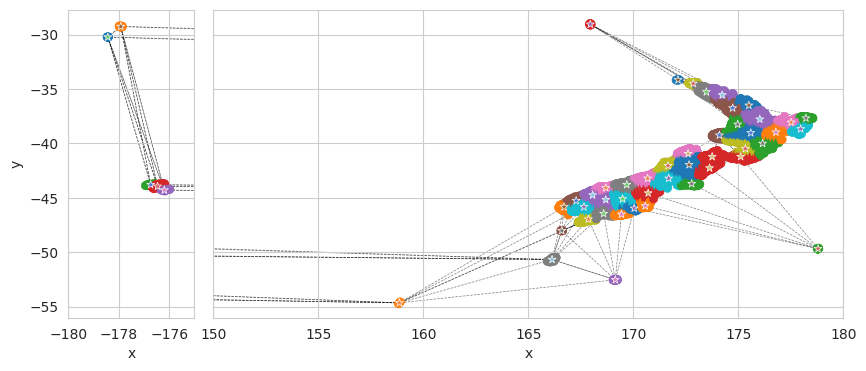

In [221]:
clustering = SpectralClustering(n_clusters=50, random_state=0).fit(space_df[['x', 'y']])
space_df['cluster'] = clustering.labels_

import torch
from torch_geometric.data import Data
from torch_geometric.transforms import KNNGraph

spatial_graph = Data(pos=torch.tensor(space_df.groupby('cluster').agg({'x': 'mean', 'y': 'mean'}).values).float())
spatial_graph = KNNGraph(k=6)(spatial_graph)

# Filter data for x < -175 and x > 150
filtered_df1 = space_df[space_df['x'] < -175]
filtered_df2 = space_df[space_df['x'] > 150]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw={'width_ratios': [1, 5], 'wspace': 0.05})

# Scatter plot for x < -175
sns.scatterplot(data=filtered_df1, x='x', y='y', hue='cluster', palette='tab10', legend=False, edgecolor=None, ax=ax1)
ax1.plot(spatial_graph.pos[spatial_graph.edge_index, 0], spatial_graph.pos[spatial_graph.edge_index, 1], '--', c='black', alpha=.5, lw=.5, zorder=0)
sns.scatterplot(data=space_df.groupby('cluster').mean(), x='x', y='y', hue='cluster', ax=ax1, palette='muted', legend=False, zorder=2, marker='*')
ax1.set_xlim(-180, -175)

# Scatter plot for x > 150
sns.scatterplot(data=filtered_df2, x='x', y='y', hue='cluster', palette='tab10', legend=False, edgecolor=None, ax=ax2)
ax2.plot(spatial_graph.pos[spatial_graph.edge_index, 0], spatial_graph.pos[spatial_graph.edge_index, 1], '--', c='black', alpha=.5, lw=.5, zorder=0)
sns.scatterplot(data=space_df.groupby('cluster').mean(), x='x', y='y', hue='cluster', ax=ax2, palette='muted', legend=False, zorder=2, marker='*')
ax2.set_xlim(150, 180)

plt.show()


## Global feats

### Climate data

In [ ]:
clim_rasters = []
mod_name = 'climatic layers'
df_path = (data_path / "complete layers"/f"{mod_name}_space_df.csv")
if df_path.exists():
    clim_df = pd.read_csv(df_path, index_col=0)
else:
    for f in tqdm(list((Path(data_path / "complete layers" / mod_name).rglob('*.tif')))):
        raster = load_raster(f)
        filt_raster = raster.interp(x=space_df.x.values, y=space_df.y.values, method='nearest').isel(band=0)
        filt_raster = filt_raster.to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': f.stem})
        clim_rasters.append(space_df.set_index(['x', 'y']).join(filt_raster.set_index(['x', 'y'])).groupby(['cluster']).mean()[f.stem])
    clim_df = pd.concat(clim_rasters, axis=1)
    clim_df.to_csv(df_path)


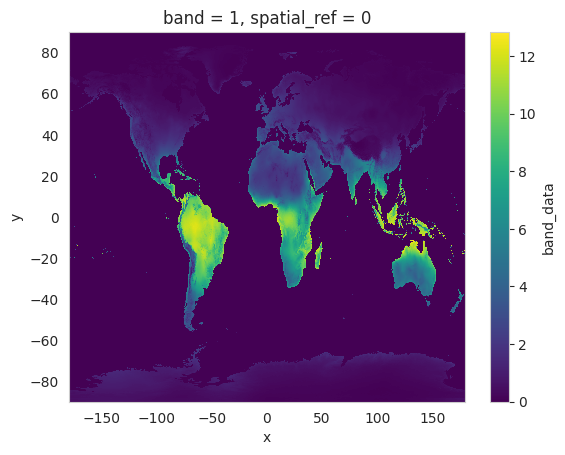

In [57]:
raster.plot()
plt.show()

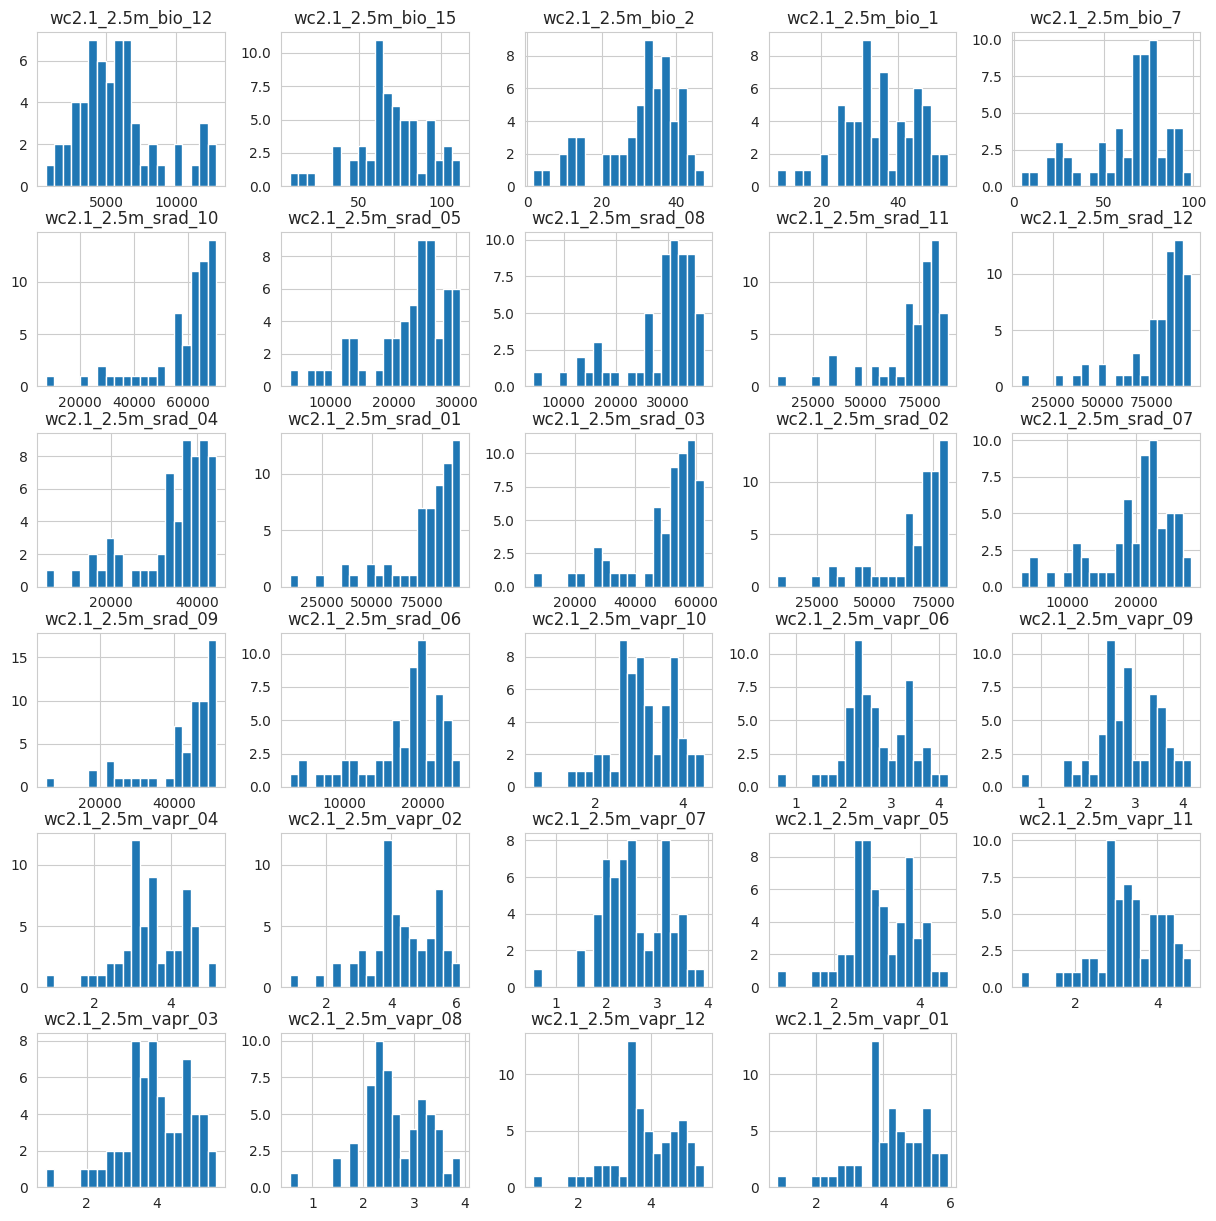

In [55]:
clim_df.hist(bins=20, figsize=(15, 15))
plt.show()

### Population


(-50.0, -34.0)

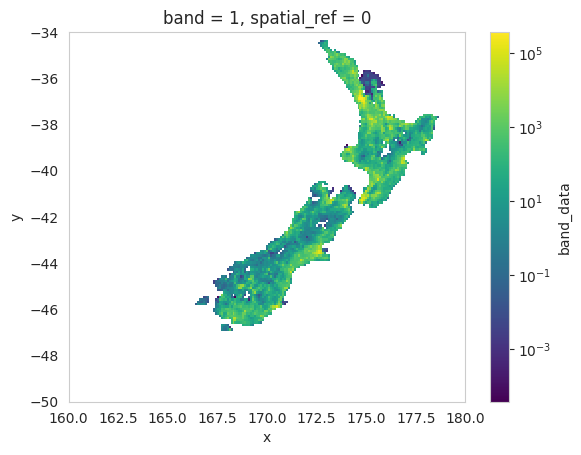

In [58]:
from matplotlib.colors import LogNorm

im_path = Path("Ferns/complete layers/population density and elevation layer/NZ population density layer.tif")
raster_population = load_raster(im_path)

xr.where(raster_population > 0, raster_population, np.nan).plot(norm=LogNorm())
plt.xlim(160, 180)
plt.ylim(-50, -34)

In [76]:
pop_rasters = []
mod_name = 'population density and elevation layer'

df_path = (data_path / "complete layers"/f"{mod_name}_space_df.csv")
if df_path.exists():
    pop_df = pd.read_csv(df_path, index_col=0)
else:
    for f in tqdm(list((Path(data_path / f"complete layers" / mod_name).rglob('*.tif')))):
        raster = load_raster(f)
        filt_raster = raster.interp(x=space_df.x.values, y=space_df.y.values, method='nearest').isel(band=0)
        filt_raster = filt_raster.to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': f.stem})
        pop_rasters.append(space_df.set_index(['x', 'y']).join(filt_raster.set_index(['x', 'y'])).groupby(['cluster']).mean()[f.stem])
        if f.stem == 'NZ population density layer':
            pop_rasters[-1] = pop_rasters[-1].apply(np.log1p).fillna(0) # no population there
    pop_df = pd.concat(pop_rasters, axis=1)
    pop_df.to_csv(df_path)


100%|██████████| 2/2 [00:12<00:00,  6.31s/it]


In [ ]:
pop_df.isna().sum()

wc2.1_2.5m_elev                0
NZ population density layer    0
dtype: int64

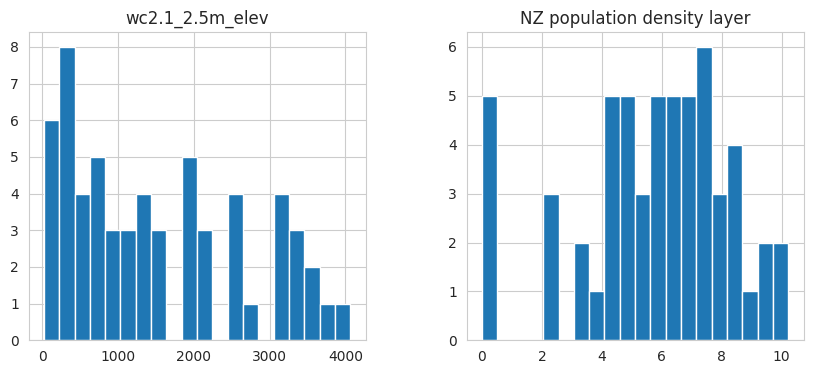

In [64]:
pop_df.hist(bins=20, figsize=(10, 4))
plt.show()

### Soil layers

In [104]:
im_path = Path("Ferns/complete layers/Soil NZ layers/ecoraster.tif")
raster_soil = load_raster(im_path)

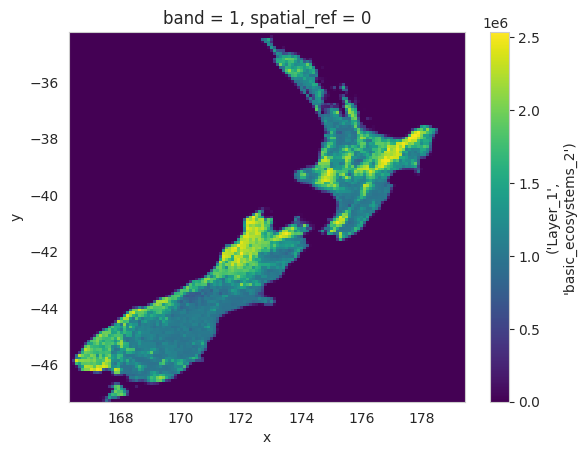

In [110]:
raster_soil.sel(band=1).plot()

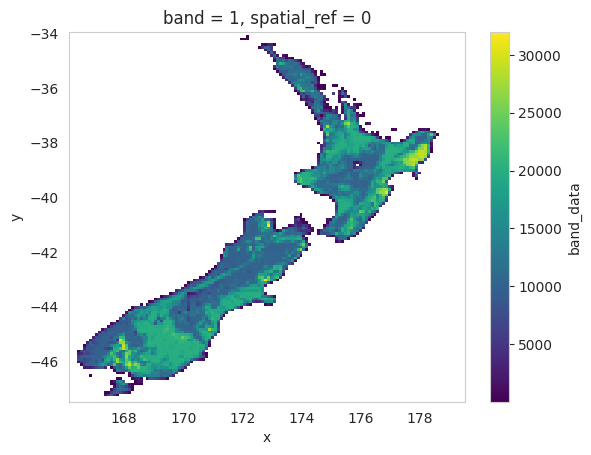

In [ ]:
im_path = Path("Ferns/complete layers/Soil NZ layers/calciumraster.tif")
raster_soil2 = load_raster(im_path)

xr.where(raster_soil2 > 0, raster_soil2, np.nan).plot()

In [68]:
soil_rasters = []
mod_name = 'Soil NZ layers'

df_path = (data_path / "complete layers"/f"{mod_name}_space_df.csv")
if df_path.exists():
    soil_df = pd.read_csv(df_path, index_col=0)
else:
    for f in tqdm(list((Path(data_path / f"complete layers" / mod_name).rglob('*.tif')))):
        raster = load_raster(f)
        filt_raster = raster.interp(x=space_df.x.values, y=space_df.y.values, method='nearest').isel(band=0)
        filt_raster = filt_raster.to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': f.stem})
        soil_rasters.append(space_df.set_index(['x', 'y']).join(filt_raster.set_index(['x', 'y'])).groupby(['cluster']).mean()[f.stem])
    soil_df = pd.concat(soil_rasters, axis=1)
    soil_df.to_csv(df_path)


100%|██████████| 9/9 [08:44<00:00, 58.31s/it] 


In [82]:
soil_df.isna().sum()


pHraster                     7
drainageraster               7
phosphorousraster            7
particle_sizeraster          7
ecoraster                    7
hardnessraster               7
soil_ageraster               7
limiation_to_growthraster    7
calciumraster                7
dtype: int64

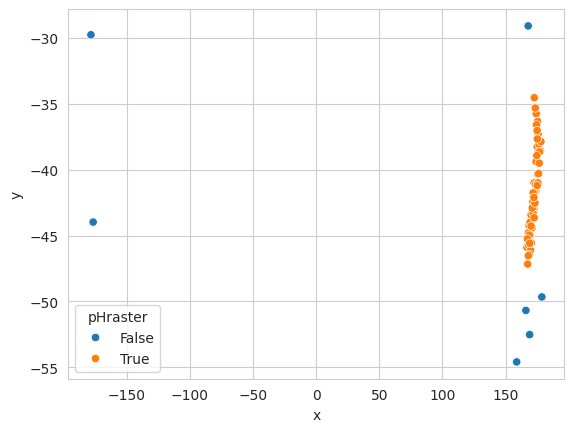

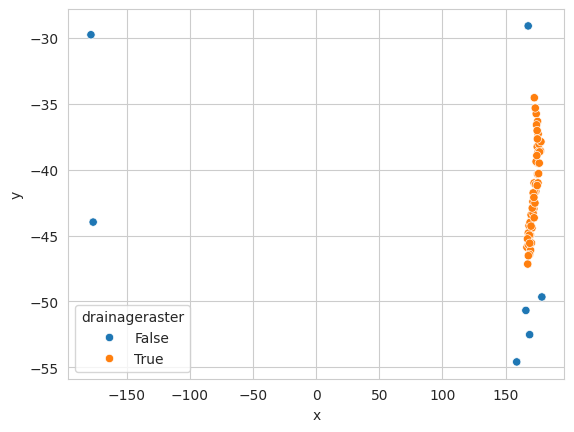

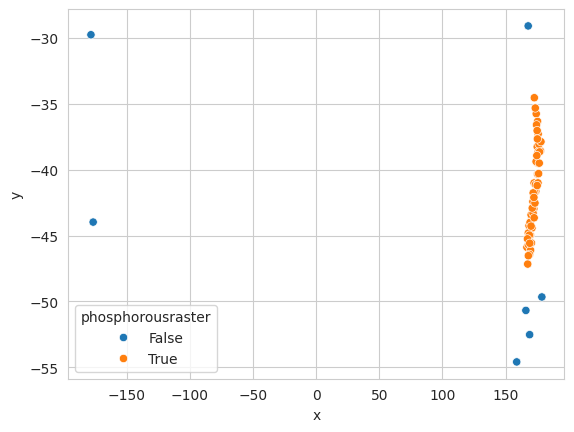

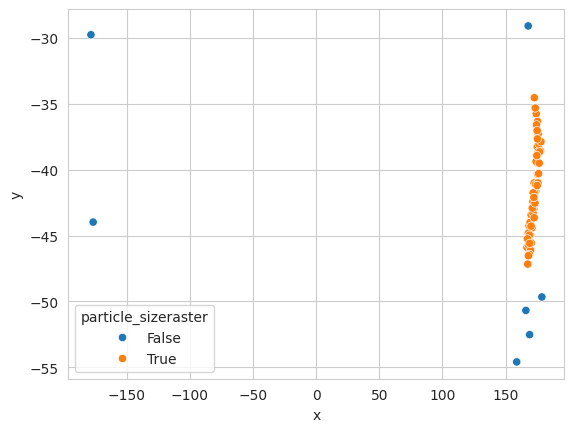

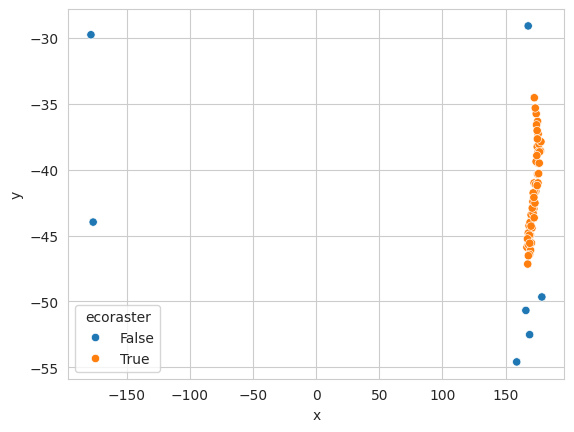

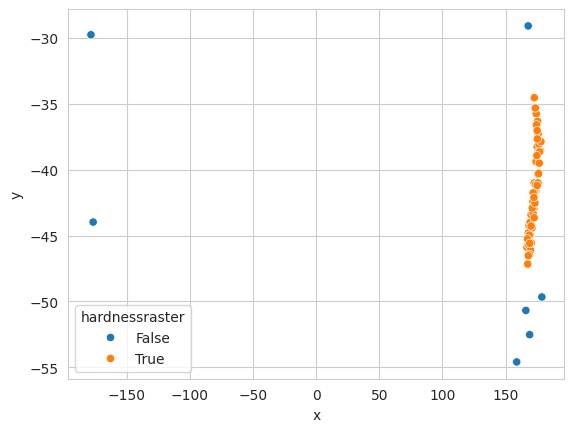

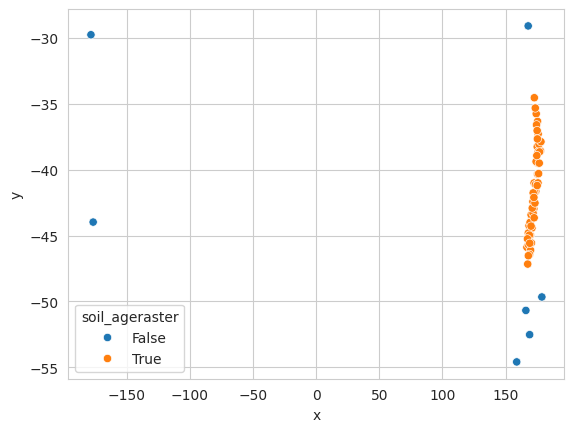

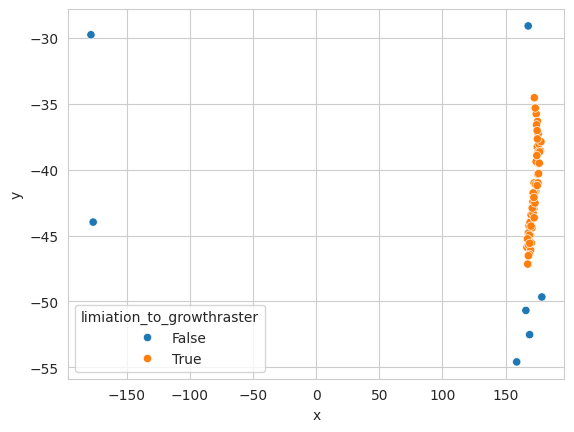

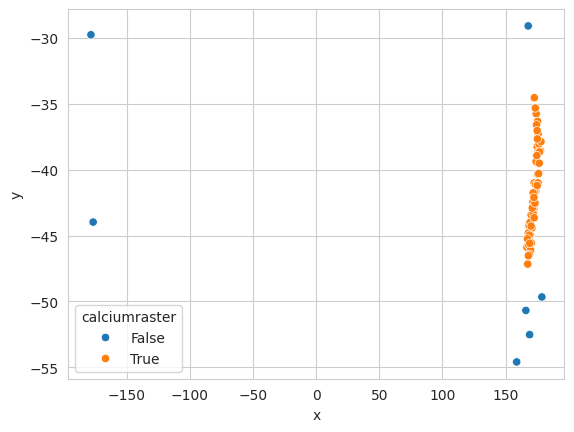

In [83]:
for c in soil_df.columns:
    sns.scatterplot(data=space_df.groupby('cluster').mean(), x='x', y='y', hue=~soil_df[c].isna(), palette='tab10')
    plt.show()

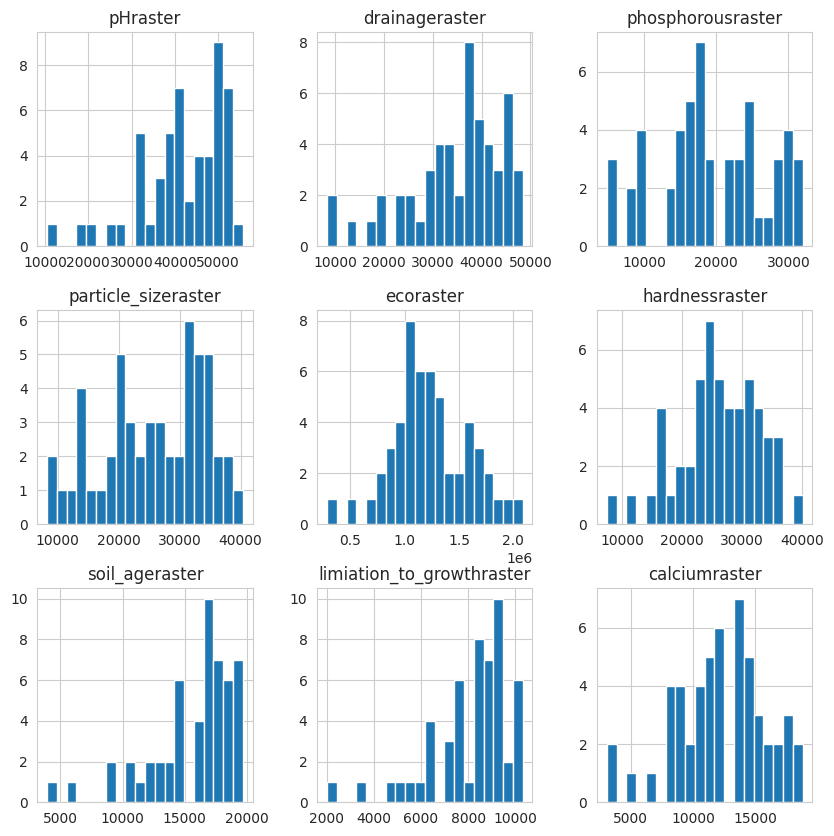

In [73]:
soil_df.hist(bins=20, figsize=(10, 10))
plt.show()

## Occurrences - Single species

In [ ]:
distributions_dir = data_path / 'Distribution layers'

In [231]:
index_space_specie = pd.DataFrame()
for f in tqdm(traits_all.index):
    raster = load_raster(distributions_dir / f"{f}_distribution.tif")
    # raster = raster.sel(x=space_df.x.values, y=space_df.y.values, method='nearest')
    occurence_df = raster.isel(band=0).to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': 'occurrence'}).astype(np.float32)
    occurence_df = occurence_df[occurence_df.occurrence > 0]
    # for each x, y; find the closest point in the space_df
    occurence_df[['x', 'y']] = occurence_df[['x', 'y']].apply(lambda x: space_df.iloc[(space_df[['x', 'y']] - x).pow(2).sum(1).idxmin()][['x', 'y']], axis=1)
    occurence_df = occurence_df.set_index(['x', 'y']).join(space_df.set_index(['x', 'y']))
    index_space_specie = pd.concat([occurence_df.groupby('cluster').sum().reset_index().assign(species=f),
                                    index_space_specie,], axis=0, ignore_index=True)

100%|██████████| 206/206 [01:33<00:00,  2.20it/s]


In [240]:
index_space_specie['species_idx'] = index_space_specie.species.apply(lambda x: species_data.node_names.index(x))
bip_edge_index = torch.tensor(index_space_specie[['cluster', 'species_idx']].values.T, dtype=torch.long)
bip_edge_attr = torch.tensor(index_space_specie.occurrence.values, dtype=torch.float32).unsqueeze(1)
Data(bip_edge_index=bip_edge_index, bip_edge_attr=bip_edge_attr)

Data(bip_edge_index=[2, 3915], bip_edge_attr=[3915, 1])

In [177]:
occurence_df['x'] = occurence_df['x'].round(1)
occurence_df['y'] = occurence_df['y'].round(1)

## Normalization

In [4]:
from loader import FernDataset
dataset = FernDataset(root=data_path, transform=None, pre_transform=None)

In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def plot_normalization(col, normalization_type):
    df = dataset.traits_all
    assert col in df.columns, f"Column {col} not found in dataset"
    assert normalization_type in ["zscore", "minmax", "log", "logz", "boxcox"], f"Normalization type {normalization_type} not recognized"

    if normalization_type == "zscore":
        norm_col = (df[col] - df[col].mean()) / df[col].std()
    elif normalization_type == "minmax":
        norm_col = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    elif normalization_type == "log":
        norm_col = np.log(df[col] + 1)
    elif normalization_type == "logz":
        norm_col = (np.log(df[col] + 1) - np.log(df[col] + 1).mean()) / np.log(df[col] + 1).std()
    elif normalization_type == "boxcox":
        norm_col, _ = stats.boxcox(df[col] + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].hist(df[col], bins=30, color='blue', alpha=0.7)
    ax[0].set_title(f"Original {col} Distribution")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Frequency")
    ax[1].hist(norm_col, bins=30, color='green', alpha=0.7)
    ax[1].set_title(f"Normalized {col} Distribution ({normalization_type})")
    ax[1].set_xlabel(f"Normalized {col}")
    ax[1].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()



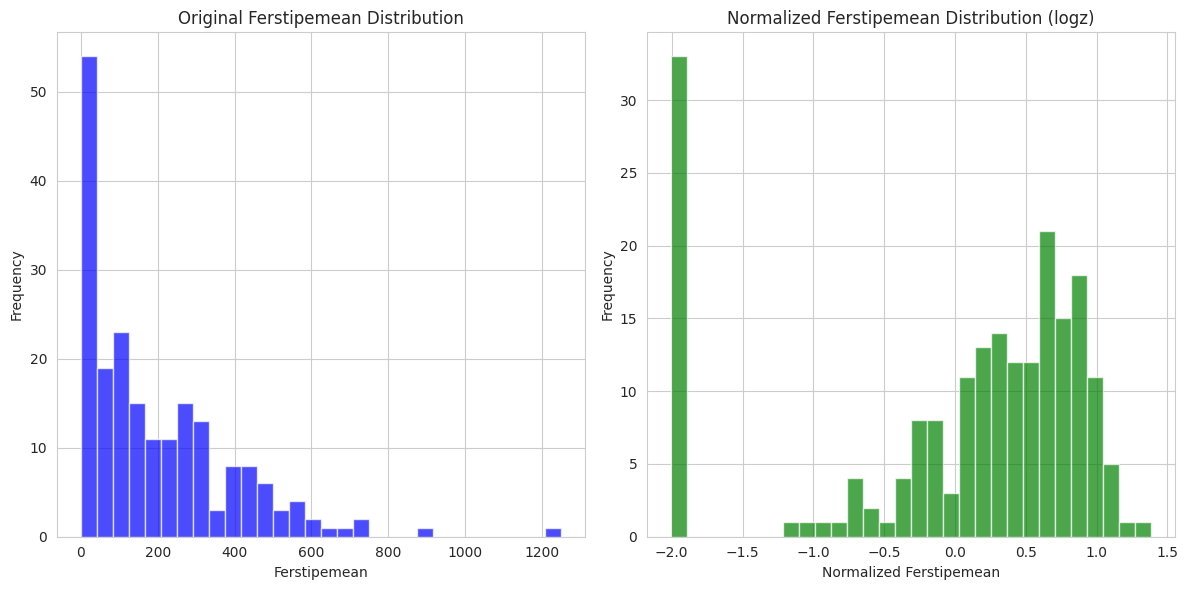

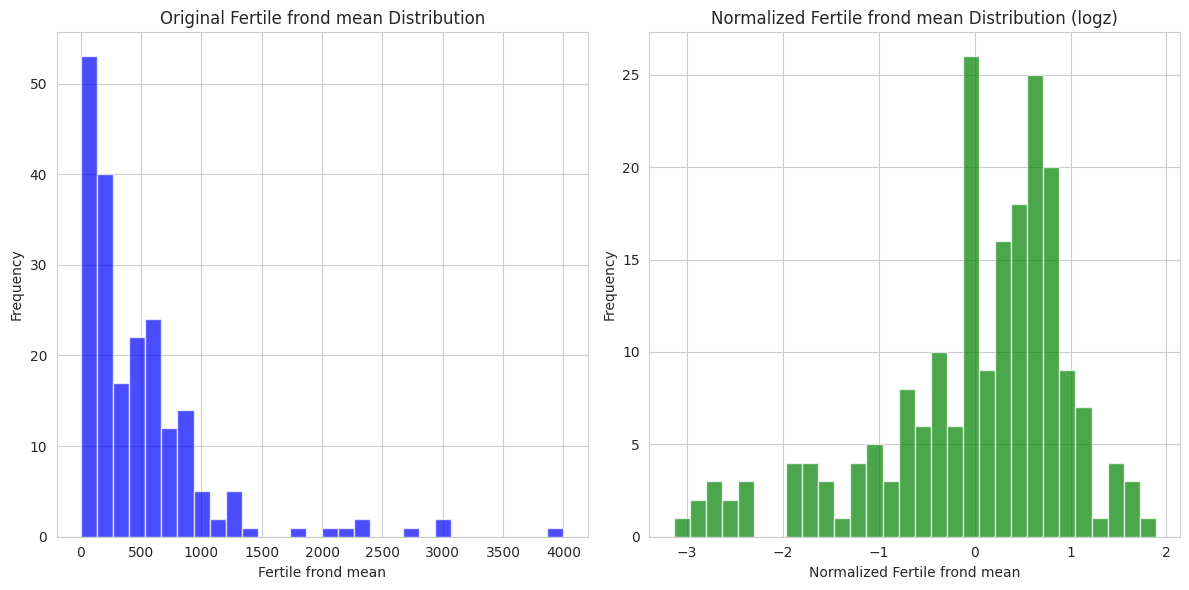

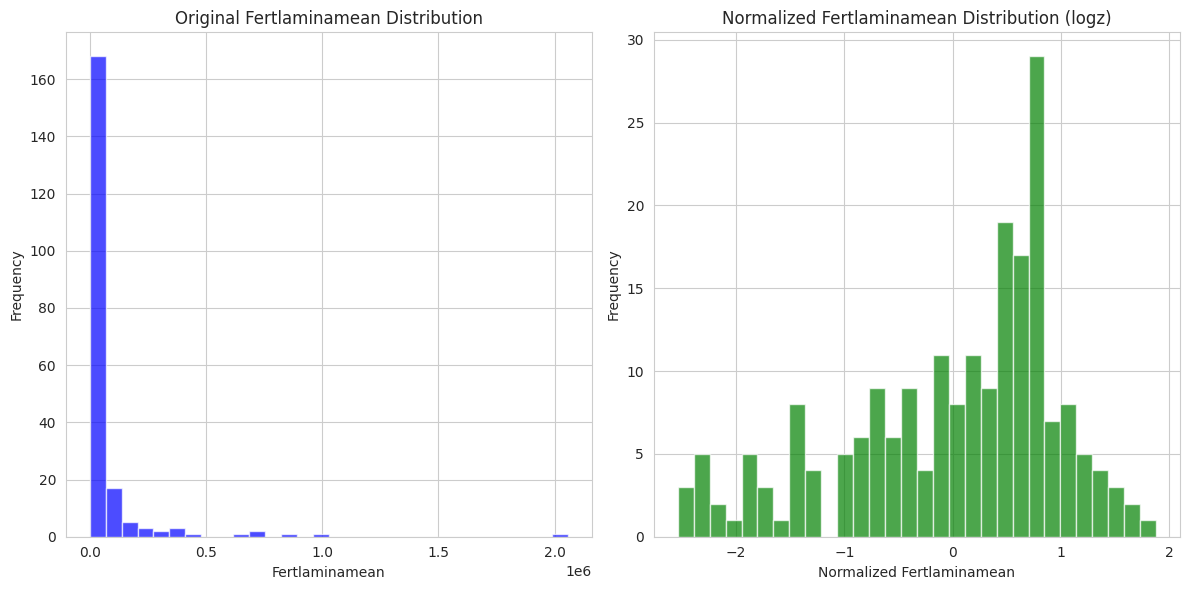

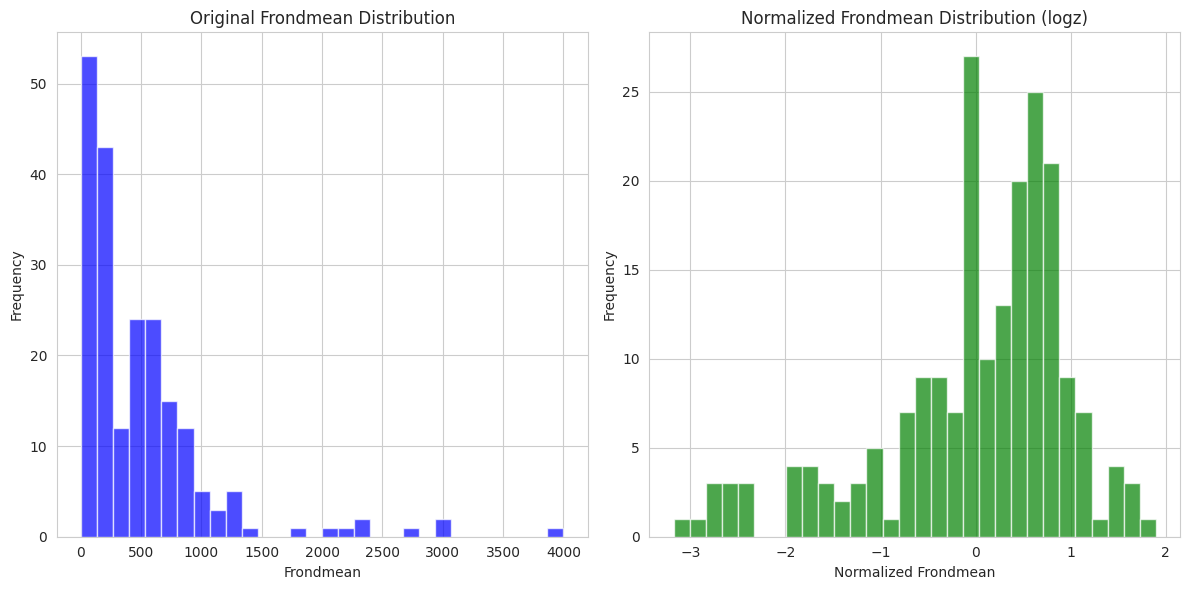

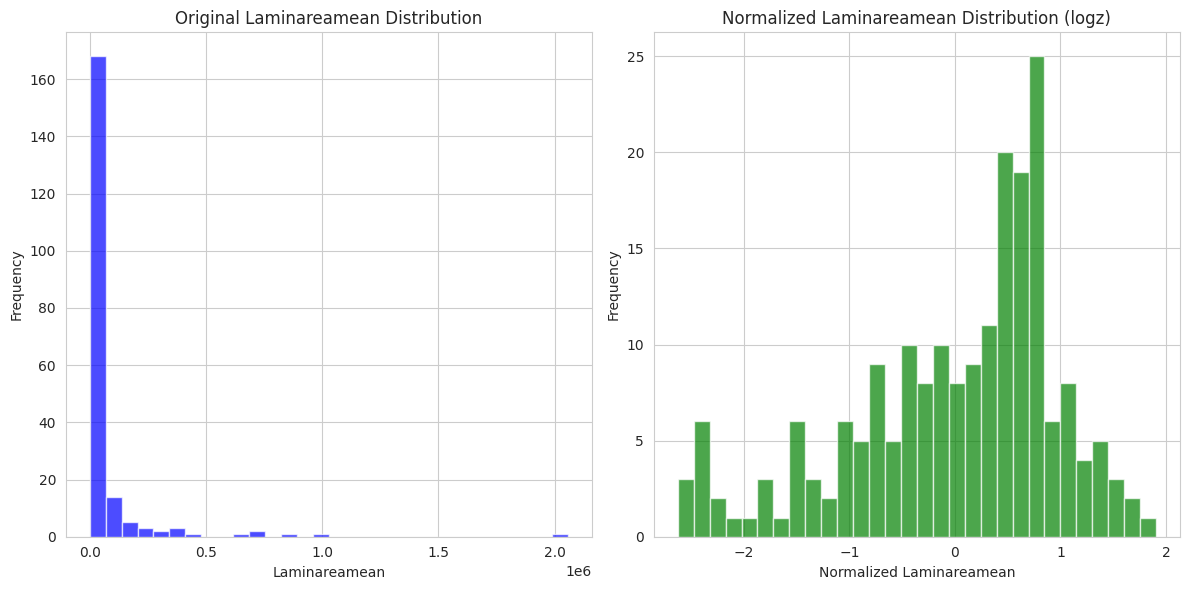

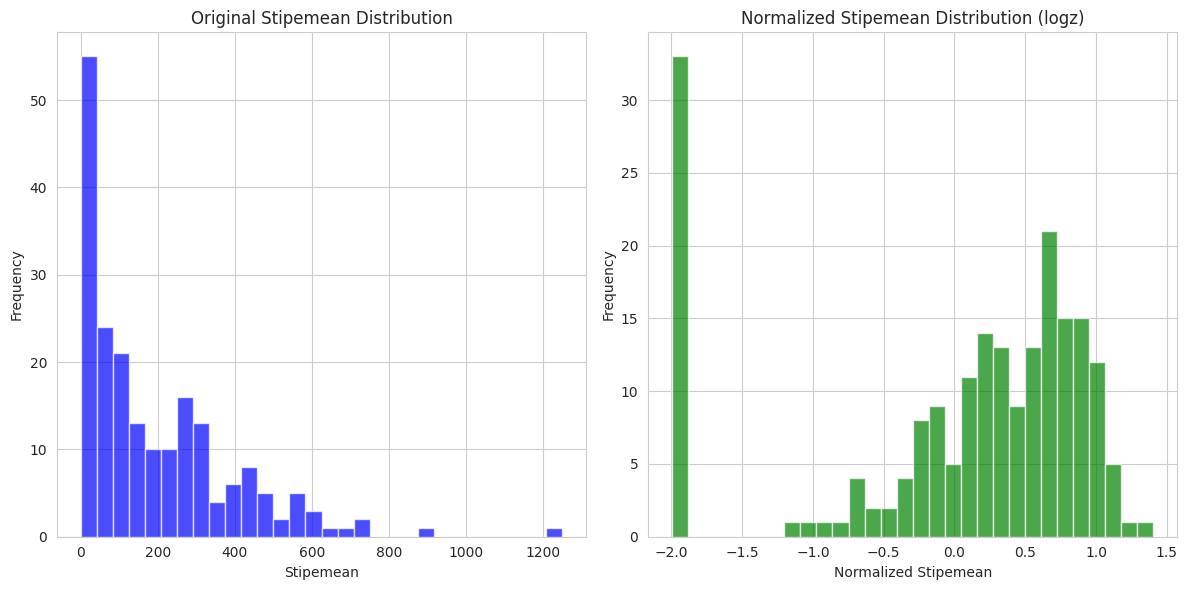

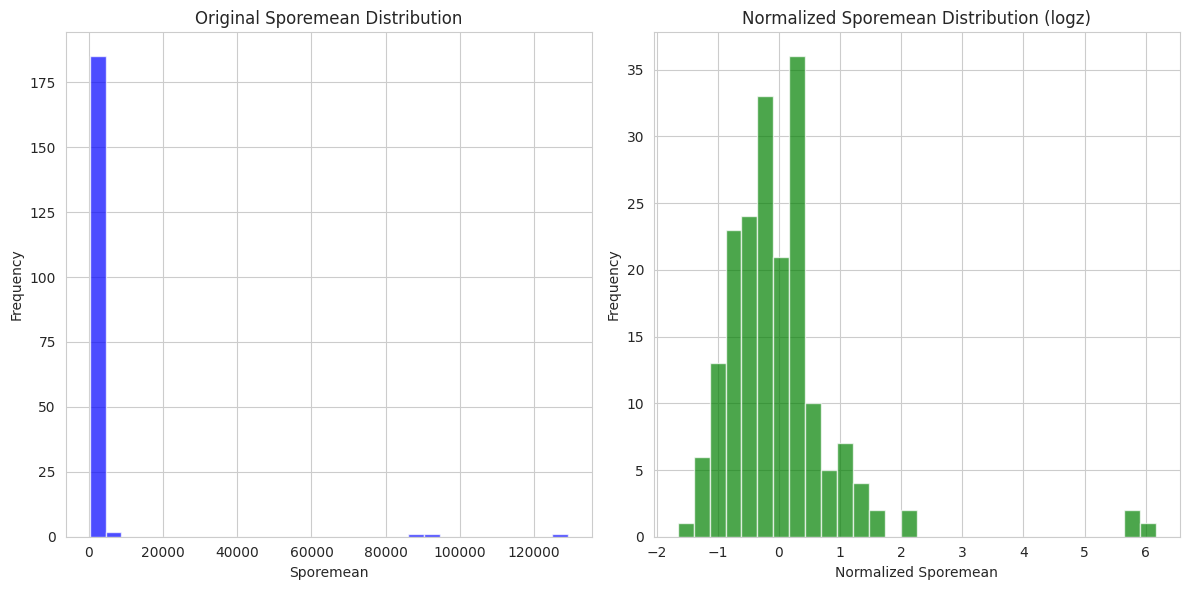

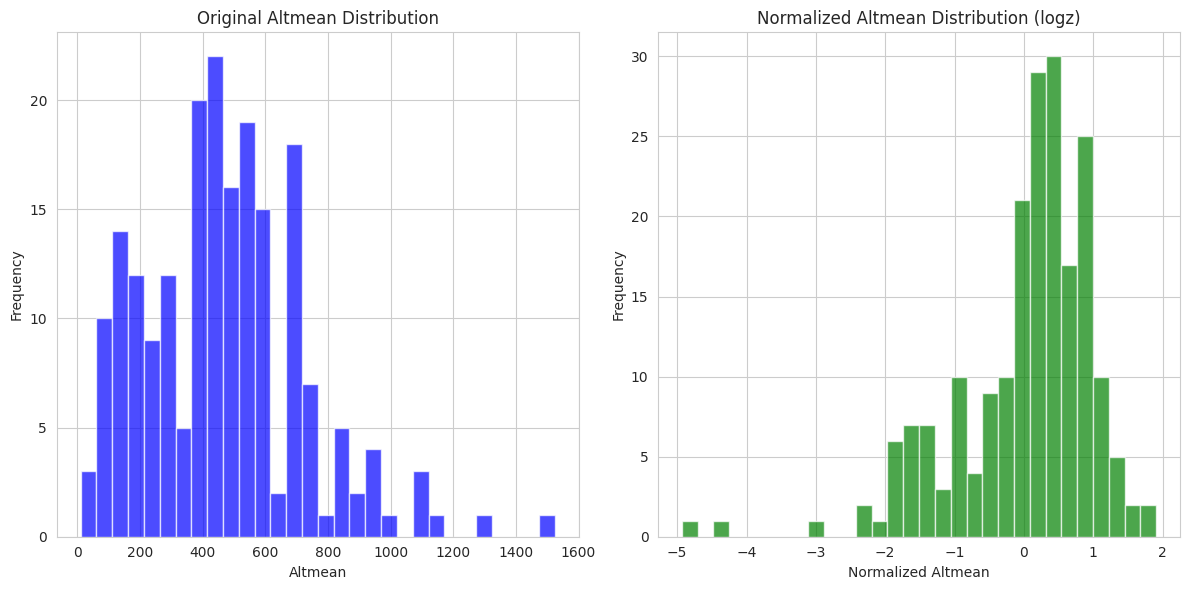

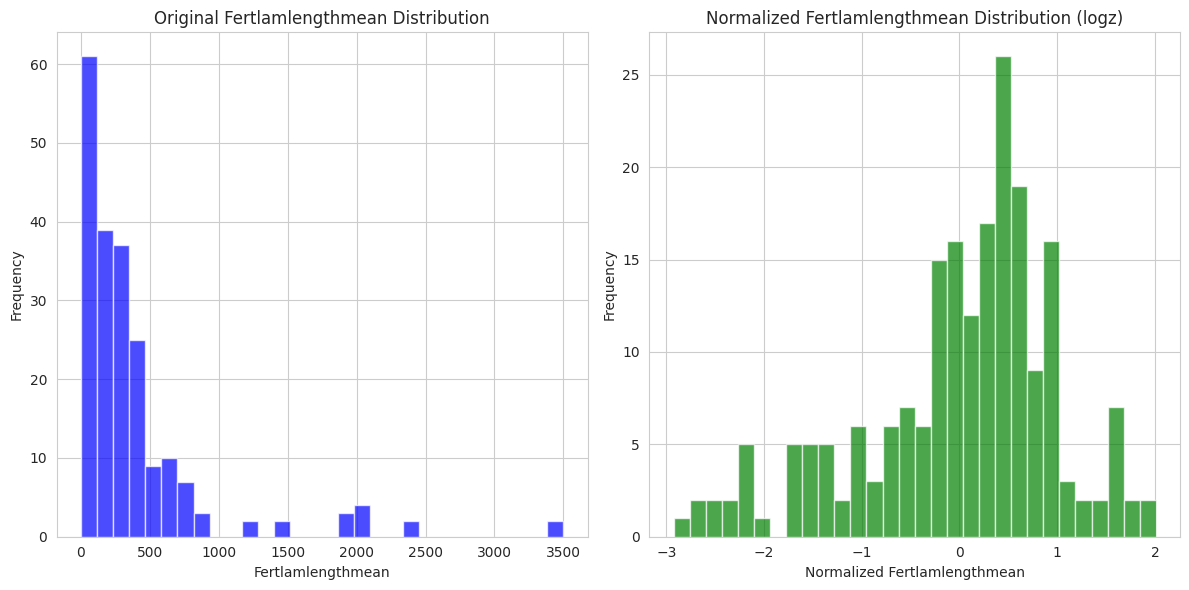

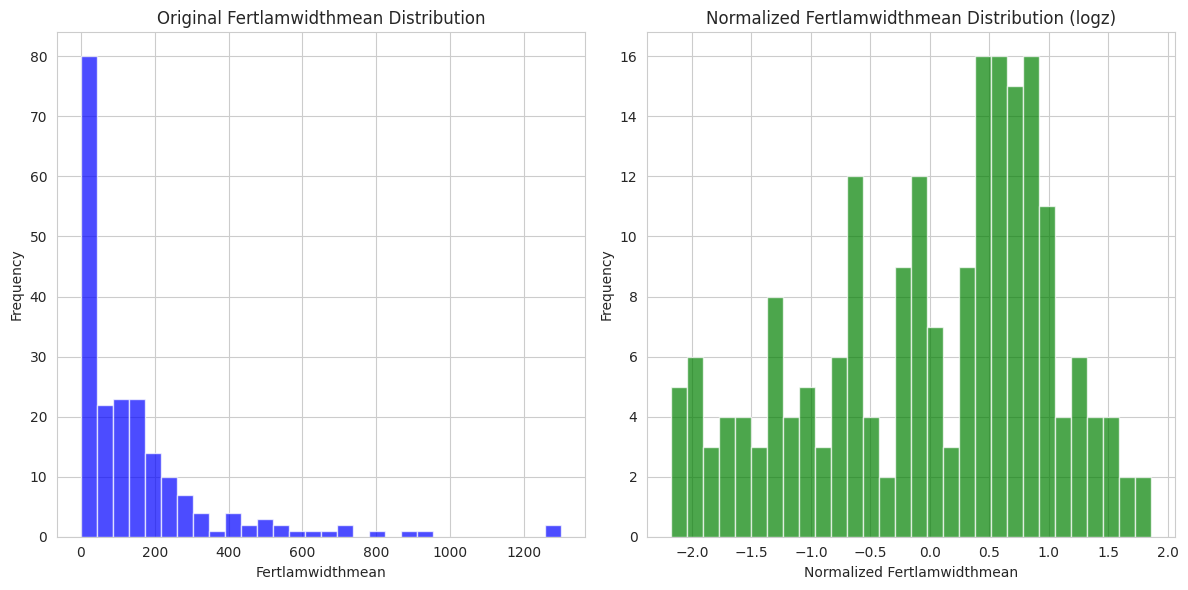

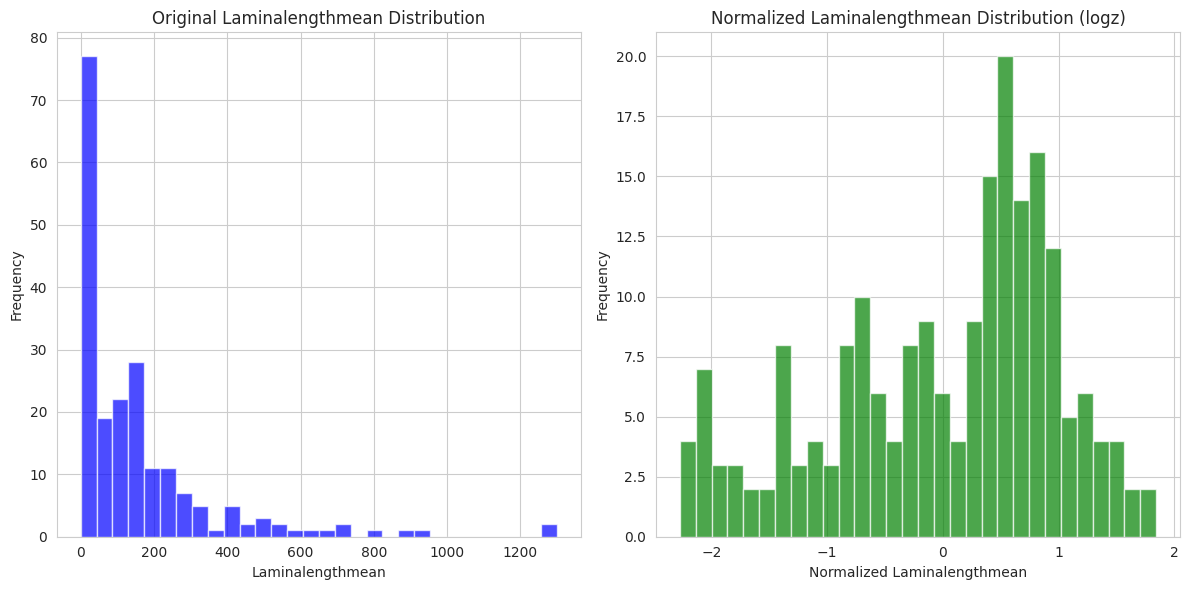

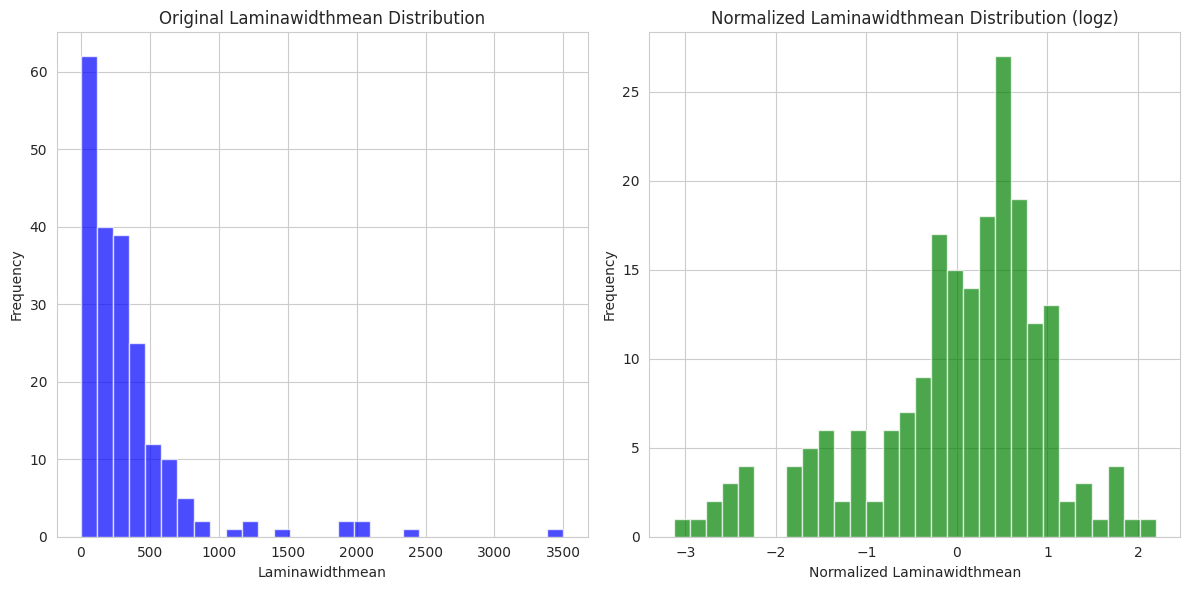

In [12]:
for col in dataset.traits_all.columns:
    if 'mean' in col.lower():
        # continue
        plot_normalization(col, 'logz')
# for col in dataset.traits_all.columns:
#     if 'std' in col.lower():
#         plot_normalization(col, 'logz')

# Training pipeline

In [31]:

from loader import FernDataset, NormalizeFeatures, data_split
from pathlib import Path

norm_transform = NormalizeFeatures()
dataset = FernDataset(Path('data/Ferns'), transform=norm_transform)
data = dataset[0]
# data = data_split(data)

In [35]:
import numpy as np
import torch
import networkx as nx
from sklearn.model_selection import GroupShuffleSplit

test_size = .3

G = nx.Graph()
G.add_nodes_from(range(data['species'].num_nodes))
G.add_edges_from(data['species', 'species'].edge_index.T.numpy())
communities = list(nx.algorithms.community.louvain_communities(G))


<Axes: title={'center': 'Number of species in each community'}, xlabel='community'>

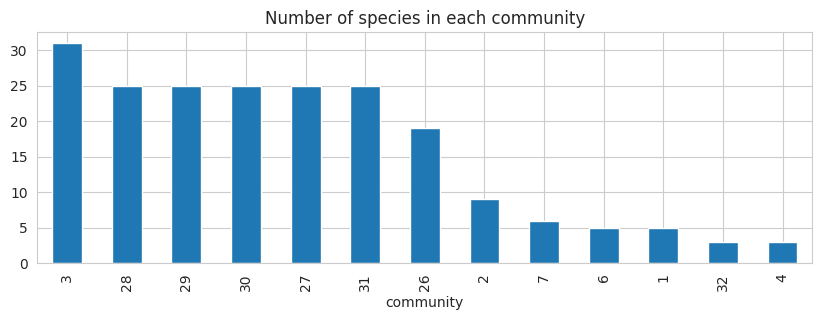

In [67]:
cs = []
for i, community in enumerate(communities):
    cs.extend(((node, i) for node in community))

cs = pd.DataFrame(cs, columns=['species_idx', 'community'])
cs.loc[cs.community.groupby(cs.community).transform('size').eq(1), 'community'] = cs.community.max() + 1

# split the bigger communities into smaller ones (if they are bigger than 1/5 of the dataset, slit by tiles of 1/5 of the community size)
for i, community in cs.groupby('community'):
    if len(community) > len(cs) / 5:
        cs.loc[community.index, 'community'] = (community.species_idx // (len(community) // 5)).astype(int) + cs.community.max() + 1

cs.community.value_counts().plot(kind='bar', figsize=(10, 3), title='Number of species in each community')

In [64]:
cs

,species_idx,community
0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0
1,"{128, 129, 130, 131, 132}",0
2,"{133, 134, 135, 136, 137, 138, 139, 140, 141}",0
3,"{142, 143, 144, 145, 146, 147, 148, 149, 150, ...",0
4,"{173, 174, 175}",0
5,{176},0
6,"{177, 178, 179, 180, 181}",0
7,"{182, 183, 184, 185, 186, 187}",0
8,{188},0
9,{189},0


In [ ]:
cs.loc[cs.community.groupby(cs.community).transform('size').eq(1), 'community'] = cs.community.max() + 1

# split the bigger communities into smaller ones (if they are bigger than 1/5 of the dataset, slit by tiles of 1/5 of the community size)
for i, community in cs.groupby('community'):
    if len(community) > len(cs) / 5:
        cs.loc[community.index, 'community'] = (community.species_idx // (len(community) // 5)).astype(int) + cs.community.max() + 1

cs.community.value_counts().plot(kind='bar', figsize=(10, 3), title='Number of species in each community')

In [59]:

splitter = GroupShuffleSplit(test_size=test_size, random_state=42, n_splits=5)
split = splitter.split(G.nodes(), groups=cs.community)
for train_nodes, test_nodes in split:
    print(f'Train nodes: {len(train_nodes)}, Test nodes: {len(test_nodes)}')

# train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
# test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

# train_mask[train_nodes] = True
# test_mask[test_nodes] = True

# if train_mask.sum() < test_mask.sum():
#     train_mask, test_mask = test_mask, train_mask
#     print(f'Warning Swapped train and test masks ()')



Train nodes: 126, Test nodes: 80
Train nodes: 132, Test nodes: 74
Train nodes: 154, Test nodes: 52
Train nodes: 161, Test nodes: 45
Train nodes: 145, Test nodes: 61


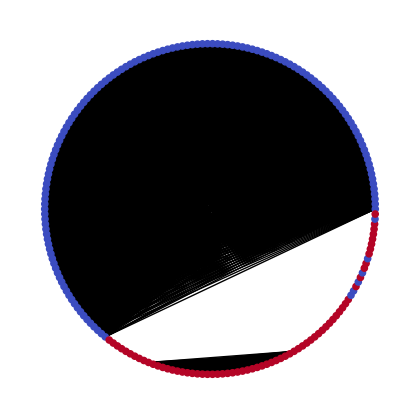

In [6]:
# plot G with the split as colors
import matplotlib.pyplot as plt
import networkx as nx

colors = 1 * data.train_mask + 3 * data.test_mask

plt.figure(figsize=(4, 4))
nx.draw_circular(G, with_labels=False, node_color=colors, cmap=plt.cm.coolwarm, node_size=20)
plt.show()

In [4]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim=1, num_layers=2, dropout=0.3):
        super(GNN, self).__init__()
        self.convs = nn.ModuleList([GATConv(in_channels, hidden_channels, edge_dim=edge_dim, dropout=dropout)])
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels, hidden_channels, edge_dim=edge_dim, dropout=dropout))
        self.convs.append(GATConv(hidden_channels, out_channels, edge_dim=edge_dim, dropout=dropout))

    def forward(self, x, edge_index, edge_attr=None):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_attr=edge_attr)
            if i < len(self.convs) - 1:
                x = x.relu()
        return x
    
class TraitsPredictor(nn.Module):
    def __init__(self, in_traits, in_phylo, in_space, hidden_channels, out_channels, num_layers, dropout=0.3):
        super(TraitsPredictor, self).__init__()
        self.space_gnn = GNN(in_space+2, hidden_channels, hidden_channels, num_layers=num_layers)
        self.bipartite_conv = GATConv((hidden_channels, -1), hidden_channels, edge_dim=1, add_self_loops=False)
        self.species_gnn = GNN(in_traits + in_phylo + hidden_channels, hidden_channels, hidden_channels, num_layers=num_layers)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        space_input = torch.cat([data.x_spatial, data.global_data], dim=1)
        space_embeddings = self.space_gnn(space_input, data.edge_index_spatial, data.edge_attr_spatial).relu()

        space_to_species = self.bipartite_conv((space_embeddings, None), data.bip_edge_index, data.bip_edge_attr,
                                               size=(space_embeddings.size(0), data.x_species.size(0)))
        # space_to_species = self.bipartite_conv((space_embeddings, torch.zeros_like(data.x_species)), data.bip_edge_index, data.bip_edge_attr)
        species_input = torch.cat([space_to_species, data.x_species, data.x_species_phylo], dim=1)
        species_embeddings = self.species_gnn(species_input, data.edge_index_species, data.edge_attr_species).relu()
        return self.fc(species_embeddings)
    
model = TraitsPredictor(in_traits=data.x_species.size(1), in_phylo=data.x_species_phylo.size(1), 
                        in_space=data.global_data.size(1), hidden_channels=16, out_channels=4, num_layers=2)

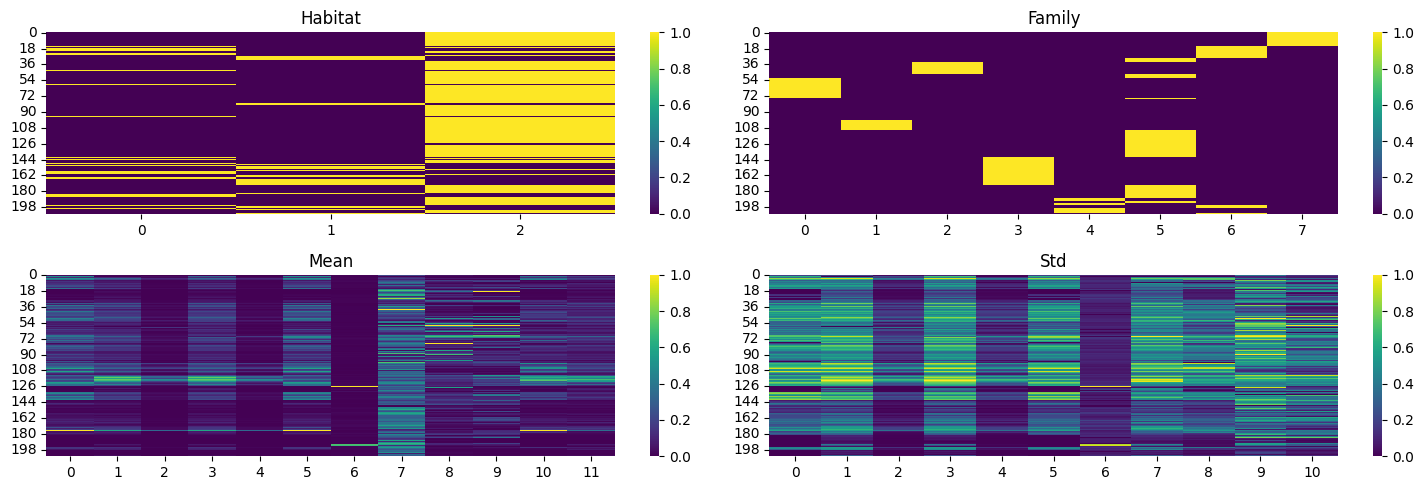

In [6]:
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax = ax.flatten()
sns.heatmap((data.x_species[:, torch.arange(len(dataset.traits_all.columns))[[c.startswith('Habitat') for c in dataset.traits_all.columns]]]).numpy(), cmap='viridis', ax=ax[0])
ax[0].set_title('Habitat')

sns.heatmap((data.x_species[:, torch.arange(len(dataset.traits_all.columns))[[c.startswith('Family') for c in dataset.traits_all.columns]]]).numpy(), cmap='viridis', ax=ax[1])
ax[1].set_title('Family')

sns.heatmap((data.x_species[:, torch.arange(len(dataset.traits_all.columns))[[c.endswith('mean') for c in dataset.traits_all.columns]]]).numpy(), cmap='viridis', ax=ax[2])
ax[2].set_title('Mean')

sns.heatmap((data.x_species[:, torch.arange(len(dataset.traits_all.columns))[[c.endswith('Std') for c in dataset.traits_all.columns]]]).numpy(), cmap='viridis', ax=ax[3])
ax[3].set_title('Std')
plt.tight_layout()

In [10]:
data.x_species_traits_nanmask = data.x_species_traits_nanmask[:, dataset.y_index]

In [13]:
torch.save(data, 'data.pt')

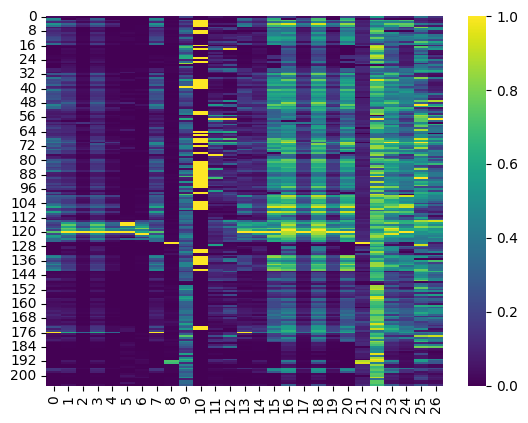

In [12]:
g = sns.heatmap((data.x_species[:, dataset.y_index]*~data.x_species_traits_nanmask).numpy(), cmap='viridis')

In [ ]:
from tqdm.auto import trange
from torch_geometric.utils import subgraph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_mask = train_mask.to(device)
test_mask = test_mask.to(device)
data_y = data.x_species[:, dataset.y_index]*~data.x_species_traits_nanmask

train_data = data.clone()
test_data = data.clone()
for attr in ['x_species', 'x_species_phylo', 'x_species_traits_nanmask']:
    train_data[attr] = train_data[attr][train_mask]
    test_data[attr] = test_data[attr][test_mask]
train_data.edge_index_species, train_data.edge_attr_species = subgraph(train_mask, train_data.edge_index_species, data.edge_attr_species, relabel_nodes=True)
test_data.edge_index_species, test_data.edge_attr_species = subgraph(test_mask, test_data.edge_index_species, data.edge_attr_species, relabel_nodes=True)

In [16]:
model = model.to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
Loss = []
test_losses = []
for epoch in trange(200):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    out = out*[~data.x_species_traits_nanmask]
    loss = loss_fn(out, data_y)
    loss.backward()
    optimizer.step()
    Loss.append(loss.item())
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            out = model(test_data)
            test_loss = loss_fn(out, data_y)
            test_losses.append(test_loss.item())


  0%|          | 0/200 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [1,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [2,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [3,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [8,0,0], thread: [4,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKern

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Performance evaluation

In [2]:
import pytorch_lightning as pl
from models import TraitsPredictor
from loader import FernDataset, NormalizeFeatures, data_split, NZData
from pathlib import Path
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
torch.serialization.add_safe_globals([NZData])

In [4]:
attrib_species = pd.read_csv('attributions_species_fold.csv', index_col=0)
attrib_spatial = pd.read_csv('attributions_spatial_fold.csv', index_col=0)
attrib_species.shape, attrib_spatial.shape  

((5356, 40), (5356, 92))

In [5]:
attrib_species

,Fertile frond mean,Fertlaminamean,Frondmean,Laminareamean,Rhizomelength,Rhizomewidth,Stipemean,Sporemean,Altmean,Hybridisation,...,Family_Lycopodiaceae,Family_Other,Family_Polypodiaceae,Family_Pteridaceae,Habitat_epiphytic,Habitat_occasionally epiphytic,Habitat_terrestrial,dest_feature,fold,Phylo
Pellaea_rotundifolia,0.001357,0.007130,0.022888,0.004318,-0.009036,0.008244,0.017157,-0.003940,-0.001458,0.000405,...,0.001283,0.005224,-0.016778,0.035875,-0.002804,-0.002340,0.007396,Ferstipemean,0,-0.006971
Adiantum_formosum,0.004023,0.020190,0.030265,0.012438,-0.008024,0.009173,0.018129,-0.002858,0.003785,0.000989,...,0.001003,0.003858,-0.013124,0.026826,-0.002303,-0.002583,0.006197,Ferstipemean,0,-0.005668
Notogrammitis_angustifolia,0.001265,-0.039742,-0.028436,-0.011987,0.017876,-0.008959,-0.116408,-0.000552,-0.004614,0.064348,...,0.002265,0.002089,0.251120,-0.010845,-0.026138,0.004750,-0.051670,Ferstipemean,0,0.005570
Notogrammitis_billardierei,-0.003772,-0.052983,-0.039225,-0.019924,0.015665,0.014505,-0.151681,0.000272,-0.020010,0.061136,...,0.005909,0.017381,0.430166,-0.013932,0.034396,-0.003139,-0.039427,Ferstipemean,0,0.007213
Notogrammitis_heterophylla,0.000731,-0.017185,-0.001141,-0.011340,0.013876,-0.030108,0.010594,-0.004409,0.000759,0.017031,...,-0.001708,-0.002243,0.153626,-0.004967,-0.004664,-0.000619,-0.044279,Ferstipemean,0,0.007277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Brownseya_serpentina,0.002203,0.047236,0.108675,-0.026920,0.000136,-0.051530,0.065575,-0.007571,0.006356,0.002748,...,-0.214697,-0.017906,0.006896,0.006753,0.002562,0.009748,-0.007914,FertlaminawidthStd,4,0.000000
Lateristachys_diffusa,0.026236,0.039653,0.037477,-0.028406,-0.017768,-0.038197,0.060257,-0.019401,-0.003734,0.000215,...,-0.213436,-0.027588,0.013268,0.006263,-0.001808,0.002047,-0.004762,FertlaminawidthStd,4,0.000000
Lecanopteris_scandens,0.008424,0.002246,-0.006906,-0.006244,-0.027888,-0.021132,-0.005871,-0.019540,0.000421,0.031027,...,0.017373,-0.001526,-0.130766,0.004477,0.005719,-0.018792,0.010571,FertlaminawidthStd,4,0.000000
Phylloglossum_drummondii,-0.008073,0.033265,0.048677,-0.039039,0.001340,0.050186,0.071853,-0.002995,0.007493,0.006997,...,-0.234323,-0.008482,0.008664,0.002461,0.005690,0.008679,-0.010813,FertlaminawidthStd,4,0.000000


In [2]:
from argparse import Namespace

args = Namespace(
    gnn_module='GATv2Conv',
    hidden_channels=128,
    num_layers=3,
    dropout=0.0,
)

In [9]:
dataset.get_spatial_graph()

/home/smonaco/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Data(pos=[50, 2], edge_index=[2, 300], edge_attr=[300, 1])

In [20]:
data.spatial_global_data.shape

torch.Size([50, 87])

In [26]:
len([c for c in attrib_spatial.columns if c.startswith('Spatial')])

90

In [27]:
x_spatial = torch.cat([test_data.spatial_x, test_data.spatial_global_data], axis=1)
N_species = test_data.species_x.shape[0]
F_spatial = x_spatial.shape[1]
F_spatial

91

In [ ]:
space_cols = ['lon_1', 'lon_2', 'lat_1', 'lat_2'] +\
             dataset.load_complete('climatic layers').columns.tolist() + \
             dataset.load_complete('population density and elevation layer').columns.tolist() + \
             dataset.load_complete('Soil NZ layers').columns.tolist()
attrib_spatial


ValueError: Length mismatch: Expected axis has 92 elements, new values have 91 elements

In [17]:
data.spatial_pos

tensor([[ 175.0078,  -37.3619],
        [ 158.8497,  -54.6596],
        [ 178.7997,  -49.7096],
        [-178.4503,  -30.2596],
        [-177.9503,  -29.2596],
        [ 169.0997,  -52.5346],
        [ 167.9397,  -29.0796],
        [ 166.5997,  -48.0096],
        [ 175.1960,  -40.1386],
        [ 172.0997,  -34.1596],
        [ 172.6567,  -42.6875],
        [-176.4929,  -43.9522],
        [ 172.8711,  -34.5525],
        [ 166.1197,  -50.6929],
        [ 170.7259,  -43.2465],
        [ 175.2695,  -41.2358],
        [ 168.4540,  -45.3411],
        [ 174.8753,  -38.7118],
        [ 172.8549,  -41.6100],
        [ 167.8364,  -46.9996],
        [ 166.7291,  -45.8772],
        [ 178.1126,  -37.7693],
        [ 171.7573,  -43.1832],
        [ 170.5430,  -45.5929],
        [ 173.3700,  -35.0758],
        [ 169.6926,  -43.9131],
        [ 169.5019,  -45.0497],
        [ 177.9111,  -38.6482],
        [ 177.2697,  -38.2121],
        [ 168.7186,  -46.4326],
        [ 173.6954,  -42.0809],
        

In [12]:
global_data

,wc2.1_2.5m_bio_12_1,wc2.1_2.5m_bio_15_1,wc2.1_2.5m_bio_2_1,wc2.1_2.5m_bio_1_1,wc2.1_2.5m_bio_7_1,wc2.1_2.5m_srad_10_1,wc2.1_2.5m_srad_05_1,wc2.1_2.5m_srad_08_1,wc2.1_2.5m_srad_11_1,wc2.1_2.5m_srad_12_1,...,wc2.1_2.5m_vapr_09_1,wc2.1_2.5m_vapr_04_1,wc2.1_2.5m_vapr_02_1,wc2.1_2.5m_vapr_07_1,wc2.1_2.5m_vapr_05_1,wc2.1_2.5m_vapr_11_1,wc2.1_2.5m_vapr_03_1,wc2.1_2.5m_vapr_08_1,wc2.1_2.5m_vapr_12_1,wc2.1_2.5m_vapr_01_1
cluster,,,,,,,,,,,,,,,,,,,,,
0,5386.4900,69.121090,34.485363,53.309166,71.324780,67231.710,30663.5230,37024.3830,80861.5160,89057.650,...,4.207696,5.155897,6.229726,3.827417,4.569344,4.930242,5.804818,3.911159,5.568121,6.060754
1,2995.5000,50.291523,9.838657,13.352711,22.629750,34957.000,6795.5000,11383.0000,47030.0000,53314.500,...,1.967165,2.315349,2.585850,1.966479,2.091031,2.153849,2.401505,1.947418,2.387218,2.560721
2,790.5000,24.555420,6.456250,8.769792,13.625000,15703.500,4442.5000,6138.5000,20175.5000,22237.500,...,0.772500,0.952500,1.080000,0.797500,0.862500,0.875000,1.035000,0.787500,0.985000,1.062500
3,0.0000,0.000000,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.0000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1860.5000,18.886300,4.125833,21.993332,9.665000,18679.500,8954.0000,10756.0000,21014.5000,22321.500,...,1.462500,1.893000,2.232000,1.422500,1.667000,1.719000,2.122500,1.405000,1.966500,2.124000
5,3553.5837,23.684900,12.348799,17.166626,24.561249,35572.730,8327.6090,13272.7670,45734.5600,51767.055,...,1.969557,2.269814,2.499849,1.941486,2.104689,2.069115,2.412012,1.945271,2.345530,2.525044
6,1605.3945,24.152433,5.058304,23.709295,12.531276,24719.523,13159.6330,16038.0000,27675.3950,29308.643,...,1.690580,2.186173,2.554488,1.646733,1.948375,2.056373,2.429318,1.599722,2.291927,2.509033
7,776.0000,7.192610,1.667262,5.296131,3.885715,7540.000,2155.0000,3159.0000,9522.5000,10389.500,...,0.448571,0.525714,0.587143,0.446429,0.492143,0.482143,0.572143,0.444286,0.535000,0.575714
8,5079.3020,62.213880,32.743187,44.754790,68.945915,63768.900,26403.3950,31975.8320,78526.1640,85501.610,...,3.621616,4.331211,5.282050,3.242614,3.865092,4.205489,4.886877,3.311850,4.787472,5.210595


In [ ]:
self = dataset 
all_occurrences = self.load_raster(Path(self.root)/"Distribution layers/_all_species_distributions_with species info.tif")
self.space_df = all_occurrences.isel(band=0).to_pandas().reset_index().melt(id_vars=['y']).rename(columns={'value': 'occurrence'})
self.space_df.x = self.space_df.x.astype(float)
self.space_df.y = self.space_df.y.astype(float)
self.space_df = self.space_df[self.space_df.occurrence > 0].drop(columns='occurrence').reset_index(drop=True)

In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
seed = 42
k = 0

pl.seed_everything(seed)
torch.cuda.manual_seed(seed)

norm_transform = NormalizeFeatures()
dataset = FernDataset(Path('data/Ferns'), transform=norm_transform)
data = dataset[0]
train_data, test_data = data_split(data, k=k, seed=seed)

model = TraitsPredictor(in_traits=data.species_x.size(1), in_phylo=data.species_x_phylo.size(1), 
                        in_space=data.spatial_global_data.size(1), out_channels=data.species_y.size(1), 
                        hidden_channels=args.hidden_channels, num_layers=args.num_layers,
                        dropout=.1, gnn_module=args.gnn_module)

model_weight_path = sorted(Path.cwd().glob(f'best_model*{k}.pth'), reverse=True)[0]
model_weight = torch.load(model_weight_path, weights_only=False)
model.load_state_dict(model_weight)
model = model.to(device)
model.eval()

data = data.to(device)
test_data = test_data.to(device)
test_species = np.array(test_data.species_names)[test_data.test_mask.cpu()]
with torch.no_grad():
    test_data.to(device)
    out = model(test_data, return_attention_weights=True)

Seed set to 42


/home/smonaco/miniconda3/lib/python3.12/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([NZData])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


NameError: name 'args' is not defined

In [5]:
# convert edge_index, edge_attr to dense tensors
from torch_geometric.utils import to_dense_adj

def to_dense_adj_bip(edge_index, edge_attr, n_s=None, n_p=None):
    src_nodes = edge_index[0]  # spatial
    tgt_nodes = edge_index[1]  # plant
    N_s = n_s if n_s is not None else src_nodes.max().item() + 1
    N_p = n_p if n_p is not None else tgt_nodes.max().item() + 1

    A_bipartite = torch.zeros((N_p, N_s), device=edge_attr.device)
    A_bipartite[tgt_nodes, src_nodes] = edge_attr
    return A_bipartite

space_attention_matr = []
print(f"\nSpace")
for e_idx, edge_attr in model.space_attention_weights:
    alpha = to_dense_adj(e_idx, edge_attr=edge_attr).squeeze()
    print(alpha.shape)
    space_attention_matr.append(alpha)

print(f"\nSpecies")
species_attention_matr = []
for e_idx, edge_attr in model.species_attention_weights:
    alpha = to_dense_adj(e_idx, edge_attr=edge_attr).squeeze()
    print(alpha.shape)
    species_attention_matr.append(alpha)

print(f"\nBipartite")
# from spatial to species, then the attention matrix is bipartite
bipartite_attention_matr = []
e_idx, edge_attr = model.bip_attention_weights
alpha = to_dense_adj_bip(e_idx, edge_attr=edge_attr.squeeze()).squeeze()
print(alpha.shape)
bipartite_attention_matr.append(alpha)





Space
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50, 50])

Species
torch.Size([42, 42])
torch.Size([42, 42])
torch.Size([42, 42])

Bipartite
torch.Size([42, 50])


In [6]:
from torch_geometric.data import HeteroData
mse = torch.nn.MSELoss(reduction='none')
with torch.no_grad():
    data_out = HeteroData()
    # out_all = model(data)
    # out_all = out_all*~data.x_species_traits_nanmask
    # out = out_all[test_mask]
    out = model(test_data)
    data_out['species'].y = out
    test_rmse = mse(norm_transform.inverse(data_out.cpu(), warn=False)['species'].y,
                    norm_transform.inverse(test_data.cpu(), warn=False)['species'].y).pow(.5).numpy()
    # divide by the mean
    test_rmse = test_rmse / norm_transform.inverse(test_data.cpu(), warn=False)['species'].y.mean(axis=0, keepdim=True).numpy()

In [15]:
spatial_attention_prod = space_attention_matr[1] @ space_attention_matr[0]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(spatial_attention_prod.cpu().numpy(), cmap='viridis', ax=ax[0], square=True)
sns.heatmap(space_attention_matr[0].cpu().numpy(), cmap='viridis', ax=ax[1], square=True)
sns.heatmap(space_attention_matr[1].cpu().numpy(), cmap='viridis', ax=ax[2], square=True)
plt.tight_layout()


NameError: name 'space_attention_matr' is not defined

In [ ]:
from captum.attr import IntegratedGradients
from torch_geometric.data import Batch
import pandas as pd

species_idx = 2 
out_idx = 5

# def forward_fn(x_spatial_input, x_species_input):
def forward_fn(x_species_input, out_idx=0):
    virtual_batch = x_species_input.size(0) // test_data.species_num_nodes
    if virtual_batch > 1:
        data_exp = Batch.from_data_list([test_data] * virtual_batch)
        data_exp
    else:
        data_exp = test_data.clone()
    
    data_exp = data_exp.to(device)

    # data_exp.spatial_global_data = x_spatial_input[:, :data_exp.spatial_global_data.size(1)]
    # data_exp.spatial_x = x_spatial_input[:, data_exp.spatial_global_data.size(1):]

    data_exp.species_x = x_species_input[:, :data_exp.species_x.size(1)]
    data_exp.species_x_phylo = x_species_input[:, data_exp.species_x.size(1):]
    out = model(data_exp)
    return out

x_species = torch.cat([test_data.species_x, test_data.species_x_phylo], axis=1).to(device)
x_species.requires_grad_()

ig_spatial = IntegratedGradients(forward_fn)
attr_species = ig_spatial.attribute(inputs=x_species, target=out_idx)

# attr_species = pd.DataFrame(attr_species.cpu().detach().numpy(),
#                          index=test_species, columns=list(dataset.traits_all.columns) + [f'Phylo_{i}' for i in range(16)]).assign(dest_feature=dataset.traits_all.columns[dataset.y_index][out_idx])
# attr_species['Phylo'] = attr_species.filter(like='Phylo').mean(axis=1)
# attr_species = attr_species.drop(columns=[f'Phylo_{i}' for i in range(16)])


# ig_spatial = IntegratedGradients(forward_fn)
# attr_spatial = ig_spatial.attribute(inputs=x_spatial, target=None)

/home/smonaco/miniconda3/lib/python3.12/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'species_species_edge_attr', 'species_x', 'test_mask', 'spatial_species_edge_attr', 'train_mask', 'spatial_spatial_edge_attr', 'spatial_pos', 'species_species_edge_index', 'spatial_num_nodes', 'spatial_species_edge_index', 'traits_nanmask', 'species_num_nodes', 'species_names', 'spatial_global_data', 'species_y', 'species_x_phylo', 'spatial_x', 'spatial_spatial_edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [ ]:
# SPATIAL
from captum.attr import IntegratedGradients
from torch_geometric.data import Batch
import pandas as pd

species_idx = 2 
out_idx = 5

# def forward_fn(x_spatial_input, x_species_input):
def forward_fn(x_spatial_input):
    virtual_batch = x_spatial_input.size(0) // test_data.spatial_num_nodes
    if virtual_batch > 1:
        data_exp = Batch.from_data_list([test_data] * virtual_batch)
        data_exp
    else:
        data_exp = test_data.clone()
    
    data_exp = data_exp.to(device)

    data_exp.spatial_global_data = x_spatial_input[:, :data_exp.spatial_global_data.size(1)]
    data_exp.spatial_x = x_spatial_input[:, data_exp.spatial_global_data.size(1):]

    out = model(data_exp)
    return out[:, out_idx]

x_spatial = torch.cat([test_data.spatial_x, test_data.spatial_global_data], axis=1).to(device)
x_spatial.requires_grad_()

ig_spatial = IntegratedGradients(forward_fn)
attr_spatial = ig_spatial.attribute(inputs=x_spatial)

# attr_spatial = pd.DataFrame(attr_spatial.cpu().detach().numpy(),
#                          index=test_species, columns=list(dataset.traits_all.columns) + [f'Phylo_{i}' for i in range(16)]).assign(dest_feature=dataset.traits_all.columns[dataset.y_index][out_idx])
# attr_spatial['Phylo'] = attr_spatial.filter(like='Phylo').mean(axis=1)
# attr_spatial = attr_spatial.drop(columns=[f'Phylo_{i}' for i in range(16)])


/home/smonaco/miniconda3/lib/python3.12/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'spatial_x', 'species_species_edge_index', 'species_x_phylo', 'spatial_global_data', 'train_mask', 'traits_nanmask', 'spatial_spatial_edge_attr', 'spatial_species_edge_attr', 'species_names', 'test_mask', 'spatial_species_edge_index', 'spatial_spatial_edge_index', 'species_species_edge_attr', 'species_x', 'species_y', 'spatial_pos', 'species_num_nodes', 'spatial_num_nodes'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [19,0,0], thread: [19,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [19,0,0], thread: [20,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out o

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [7]:
dataset.traits_all.columns[dataset.y_index]#[out_idx]

Index(['Ferstipemean', 'Fertile frond mean', 'Fertlaminamean', 'Frondmean',
       'Laminareamean', 'Rhizomelength', 'Rhizomewidth', 'Stipemean',
       'Sporemean', 'Altmean', 'Fertlamlengthmean', 'Fertlamwidthmean',
       'Laminalengthmean', 'Laminawidthmean', 'FerstipeStd', 'FertfrondStd',
       'FertlaminaStd', 'FrondStd', 'LaminaStd', 'StipeStd', 'SporeStd',
       'AltRange', 'LaminalengthStd', 'LaminawidthStd', 'FertlaminalengthStd',
       'FertlaminawidthStd'],
      dtype='object')

<Axes: >

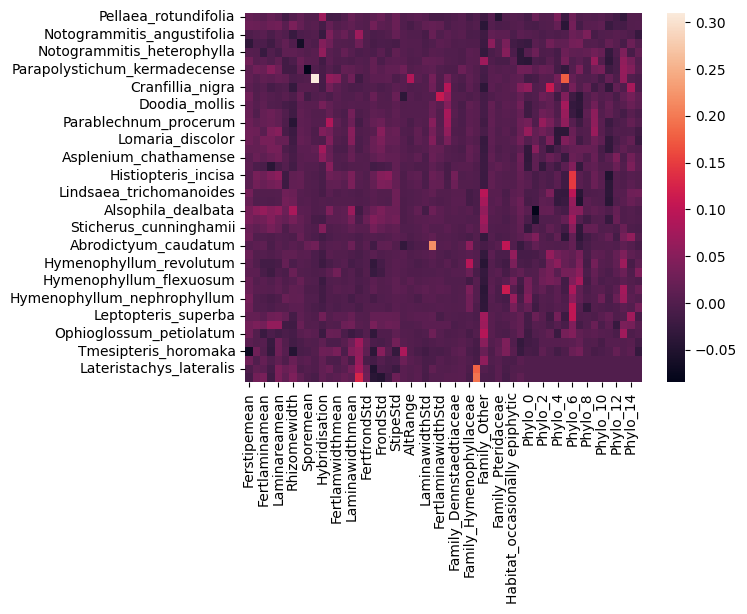

In [ ]:
import pandas as pd
sns.heatmap(

In [59]:
scaled_std[~scaled_std.index.str.endswith('Std')].to_frame().T

,Ferstipemean,Fertile frond mean,Fertlaminamean,Frondmean,Laminareamean,Rhizomelength,Rhizomewidth,Stipemean,Sporemean,Altmean,Fertlamlengthmean,Fertlamwidthmean,Laminalengthmean,Laminawidthmean,AltRange
0,1.717866,1.373869,3.869828,1.378184,3.830654,2.249451,1.553827,1.717865,4.674459,0.444485,0.962908,1.19329,1.968438,1.280589,0.267903


<Axes: xlabel='0', ylabel='index'>

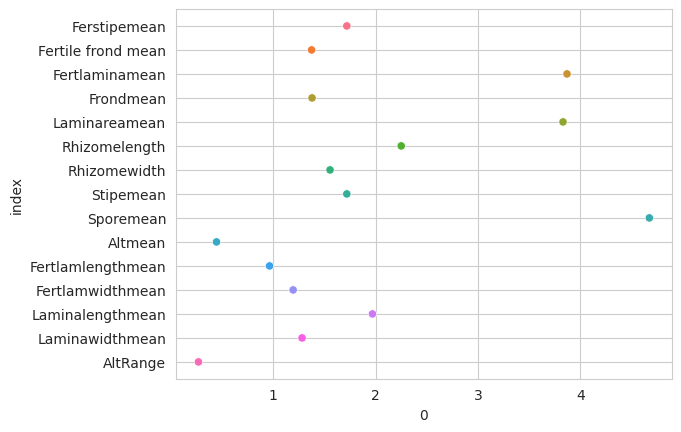

In [66]:
sns.scatterplot(data=scaled_std[~scaled_std.index.str.endswith('Std')].reset_index(), x=0, y='index', hue='index', legend=False)

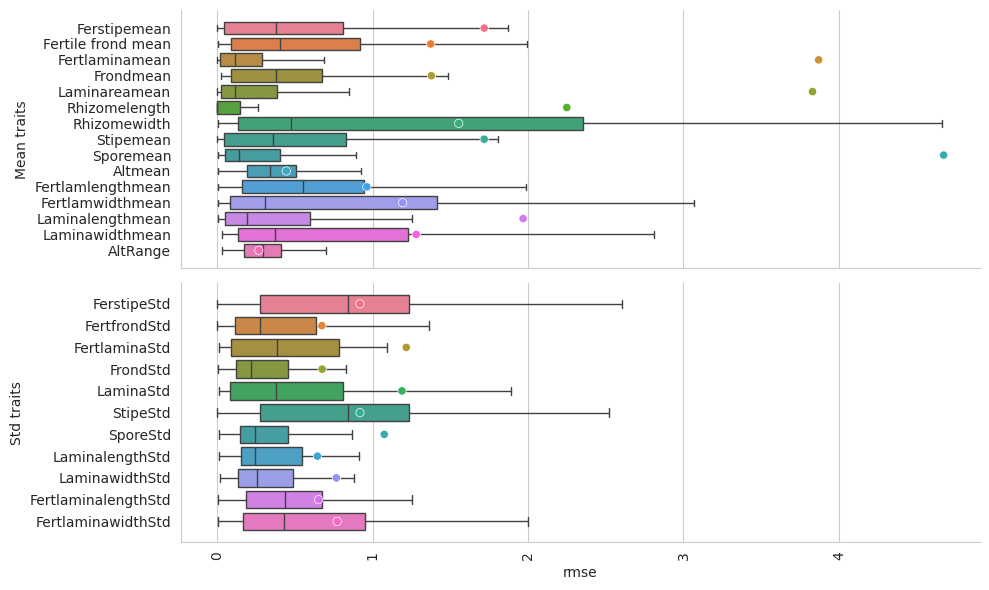

In [72]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

scaled_std = pd.Series(norm_transform.inverse(test_data.cpu(), warn=False)['species'].y.std(axis=0).numpy() / norm_transform.inverse(test_data.cpu(), warn=False)['species'].y.mean(axis=0).numpy(),
                       index=dataset.traits_all.columns[dataset.y_index])

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
test_results = pd.DataFrame(test_rmse, columns=dataset.traits_all.columns[dataset.y_index])
test_results = test_results.melt(var_name='trait', value_name='rmse')
test_results['isStd'] = test_results.trait.str.endswith('Std')
# test.result
sns.boxplot(data=test_results[~test_results.isStd], y='trait', x='rmse', hue='trait', showfliers=False, ax=ax[0])
sns.scatterplot(data=scaled_std[~scaled_std.index.str.endswith('Std')].reset_index(), x=0, y='index', hue='index', 
                legend=False, ax=ax[0], edgecolor='white', linewidth=0.5, zorder=5)
sns.boxplot(data=test_results[test_results.isStd], y='trait', x='rmse', hue='trait', showfliers=False, ax=ax[1])
sns.scatterplot(data=scaled_std[scaled_std.index.str.endswith('Std')].reset_index(), x=0, y='index', hue='index',
                legend=False, ax=ax[1], edgecolor='white', linewidth=0.5, zorder=5)

ax[0].set_ylabel('Mean traits')
ax[1].set_ylabel('Std traits')
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()
plt.show()


## Explainability

In [ ]:
data_exp = data.clone()
data_exp.species_x = torch.cat([data.species_x, data.species_x_phylo], dim=1)
data_exp.spatial_x = torch.cat([data.spatial_x, data.spatial_global_data], dim=1)

In [6]:
from explain import ModelWrap
from torch_geometric.explain import Explainer, CaptumExplainer

wmodel = ModelWrap(model)
wmodel = wmodel.to(device)
wmodel.eval()

explainer = Explainer(
    model=wmodel,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
    node_mask_type='attributes',
    # edge_mask_type='object',
    edge_mask_type=None,
    threshold_config=dict(
        threshold_type='topk',
        value=50,
    ),
)

node_index = None
feat_index = 1
print(f"Explaining node {node_index} with feature {feat_index} ({dataset.traits_all.columns[dataset.y_index][feat_index]})")


explanation = explainer(
    data_exp.x_dict,
    data_exp.edge_index_dict,
    index=node_index,
    edge_attr_dict=data_exp.edge_attr_dict,
    trait_nanmask=data_exp['species'].traits_nanmask,
)

Explaining node None with feature 1 (Fertile frond mean)


In [8]:
from torch_geometric.explain.metric import fidelity
fid_pm = fidelity(explainer, explanation)

ValueError: Fidelity not defined for 'regression' models

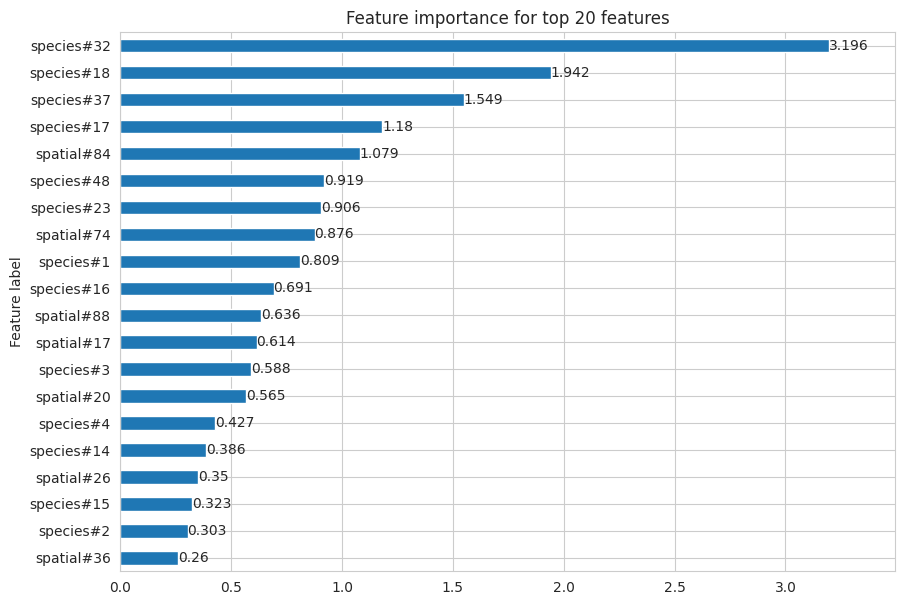

In [32]:
explanation.visualize_feature_importance(top_k=20)

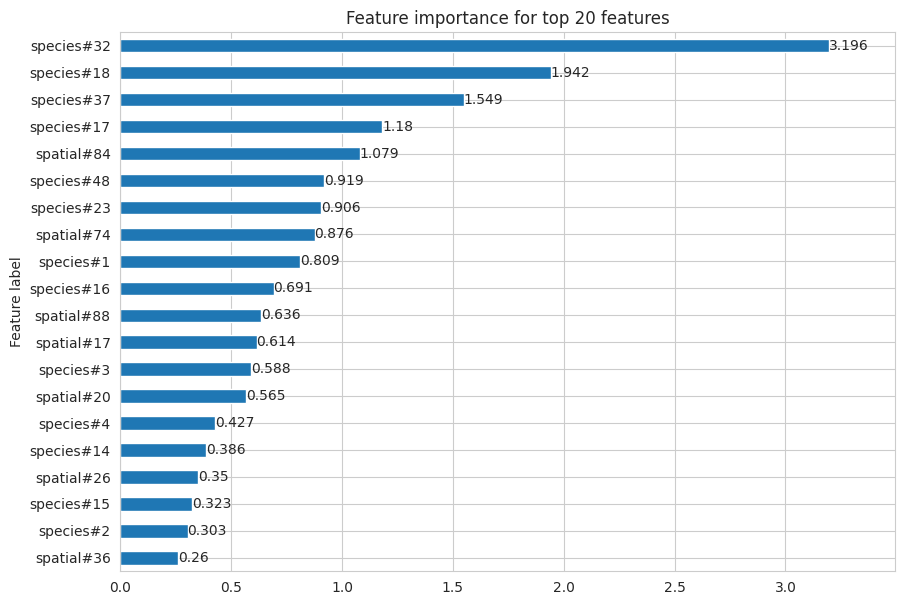

In [ ]:
explanation.visualize_feature_importance(top_k=20)